# Import Statements

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.signal import lfilter




In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

/Users/davidblumenthal/opt/miniconda3/envs/bda/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
#Utlity functions import
import sys
from pathlib import Path
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)
from preprocessing import cleaning_del
from preprocessing import smoothing_fillingNaN
from cluster import kmeans_cluster

In [3]:
print(module_path)

/Users/davidblumenthal/Documents/bda_chall/bda-analytics-challenge-template/src


# Utility functions

In [2]:
'''brauchbare Werte werden in Integer umgewandelt, Messfehler [Height > 190 & Temperatur > 100] werden bereineigt. Wobei Messfehler in Bezug auf die Höhe gelöscht werden und Temperatur Messfehler mit NaN Werten überschrieben werden '''


def cleaning_del(df):
    
    new = pd.DataFrame()
    #setting device id to join multiple bins later in the process
    new['device_id'] = df['deveui']
    #seeting time stamp
    new['time_stamp'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d')    
    #deleting rows with values height > 190 -> Measurement errors
    new['Height'] = df['Height'].str.replace('cm', '').astype(int)
    new = new[new.Height < 190]
    
    #casting temperature to int and replace values > 100 with NaN
    new['Temperature'] = df['Temperature'].str.replace('C', '').astype(int)
    new.loc[(new.Temperature > 100), 'Temperature'] = np.nan
    #casting Tilt to int
    new['Tilt'] = df['Tilt'].str.replace('Degree', '').astype(int)
    #sorting values acording to time_stamp
    new.sort_values(by=['time_stamp'], ascending=True, inplace = True)

    return new


In [3]:
''' unterschiedliche Smoothing verfahren werden angewandt - einmal auf die ungruppierten    Daten und einmal auf die gruppierten Daten. Als aggregationsfunktion wird .mean() verwendet. Als Level wird auf eintägig guppiert. 
NaN Temperaturwerte werden mit dem durchschnittlichen Temperaturwert überschrieben - gleiches gilt für Tilt.
beim mov_avg auf height werden NaN durch Interpolation gefüllt
'''

def smoothing_fillingNaN(df):
     
    #smooth with lfilter
    n = 60  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    df['lfilter'] = lfilter(b,a, df['Height'])

    #moving average smoothing
    df['mov_avg'] = df['Height'].rolling(30).mean()

    #minimum moving average
    df['min_avg'] = df['Height'].rolling(30).min()

    
    #creating new DataFrame on Level Daily with aggregation max()
    daily = df.groupby(pd.Grouper(key='time_stamp', axis=0, 
                        freq='1D', sort=True)).mean()
    #add device_id
    daily['device_id'] = df.iloc[1, 0]

    #further smoothing on daily level with rolling mean window 2
    daily['mov_avg'] = daily['Height'].rolling(2).mean()

    #fill missing values with interpolation
    df['inter_pol'] = df['mov_avg'].interpolate(limit_direction = 'both')
    daily['inter_pol'] = daily['mov_avg'].interpolate(limit_direction = 'both')
    daily.inter_pol.fillna(method = 'backfill', inplace = True)

    #fill missing NaN in DeviceID
    daily['device_id'].fillna(method = 'bfill', inplace=True)

    #fill Temperature NaN with average
    daily.Temperature.fillna(value = df.Temperature.mean(), inplace = True)
    #fill Tilt NaNs with mean
    daily.Tilt.fillna(value = daily.Tilt.mean(), inplace = True)

    return df, daily

# Calculating/Clustering different bins based on their simialarity

In [4]:
#reading in all bins and performing pre-processing

csv_folder = '../data/preprocessed/good_csv/'
csv_files = [csv for csv in os.listdir(csv_folder) if csv.endswith('.csv')]
count = 1
all_series = pd.DataFrame()
#df_list = list()

for file in csv_files:
    #print(file)
    
    # import DataFrame
    df = pd.read_csv('../data/preprocessed/good_csv/' + file)
    
    df = cleaning_del(df)
    df, grouped = smoothing_fillingNaN(df)

    #write the interpolated hight into columns
    all_series[file] = grouped['inter_pol']
    count = count + 1

In [5]:
#transform dataframe to numpy array
time_series = to_time_series_dataset(all_series)
#turn into float
time_series = time_series.astype(float)
#roate array into correct shape
a = np.rot90(time_series, k = 3)
a.shape


(42, 365, 1)

In [6]:
#scale values
train = TimeSeriesScalerMeanVariance().fit_transform(a)
#initialise cluster algorithm
dba_km = TimeSeriesKMeans(n_clusters = 3,  metric = "dtw", max_iter = 50, random_state=1)
#predict clusters and save
pred = dba_km.fit_predict(train)

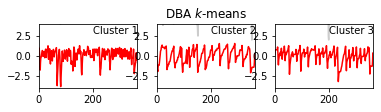

In [7]:
sz = train.shape[1]
#print sample of the different clusters
for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in a[pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

In [8]:
#transform numpy predictions to list
clust_list = pred.tolist()
#create dict with bin name and its corresponding cluster
csv_folder = '../data/preprocessed/good_csv/'
csv_files = [csv for csv in os.listdir(csv_folder) if csv.endswith('.csv')]
clusters = dict()
#df_list = list()

for file, clust in zip(csv_files, clust_list):
    
    clusters.update( {file : clust})

Directory  ../data/preprocessed/clusters/0  Created 
Cluster 0


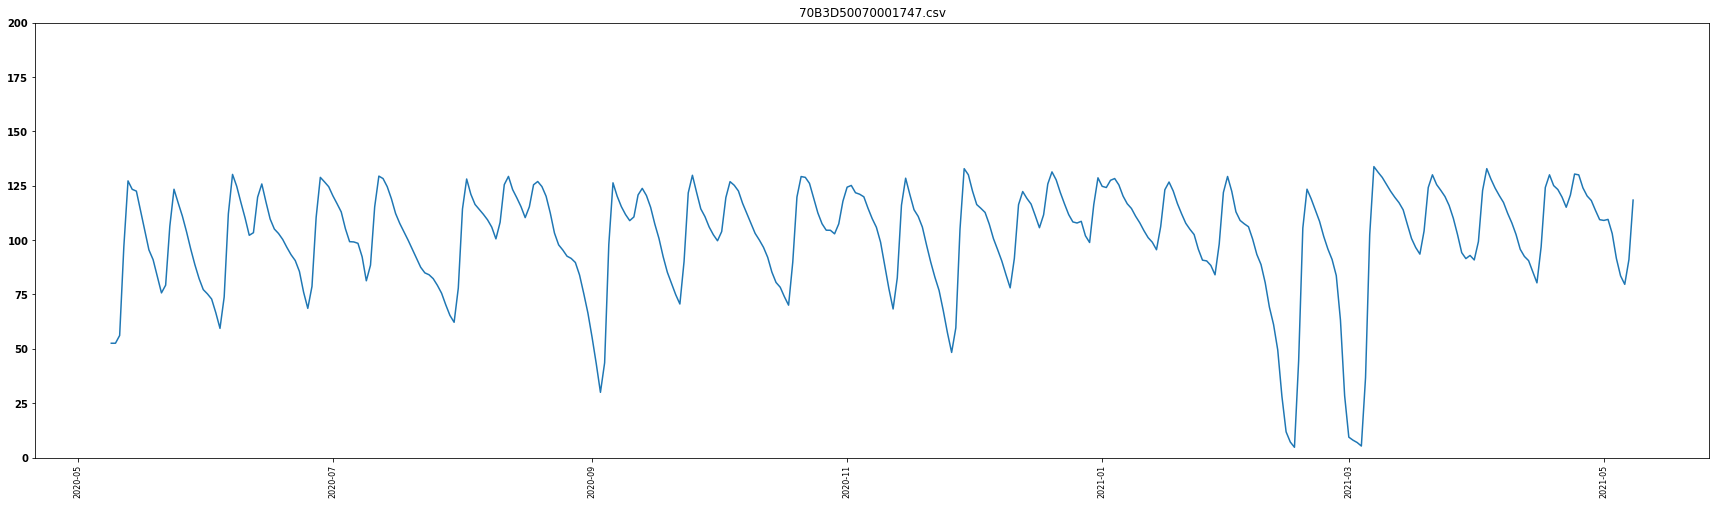

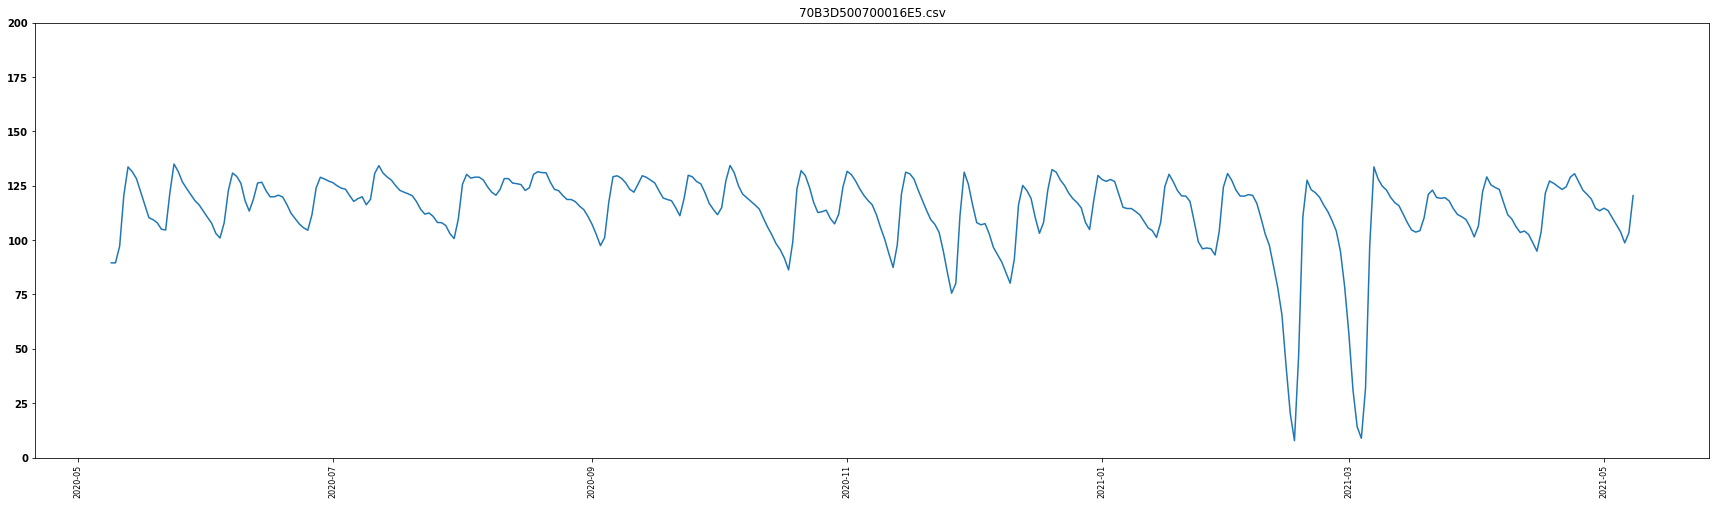

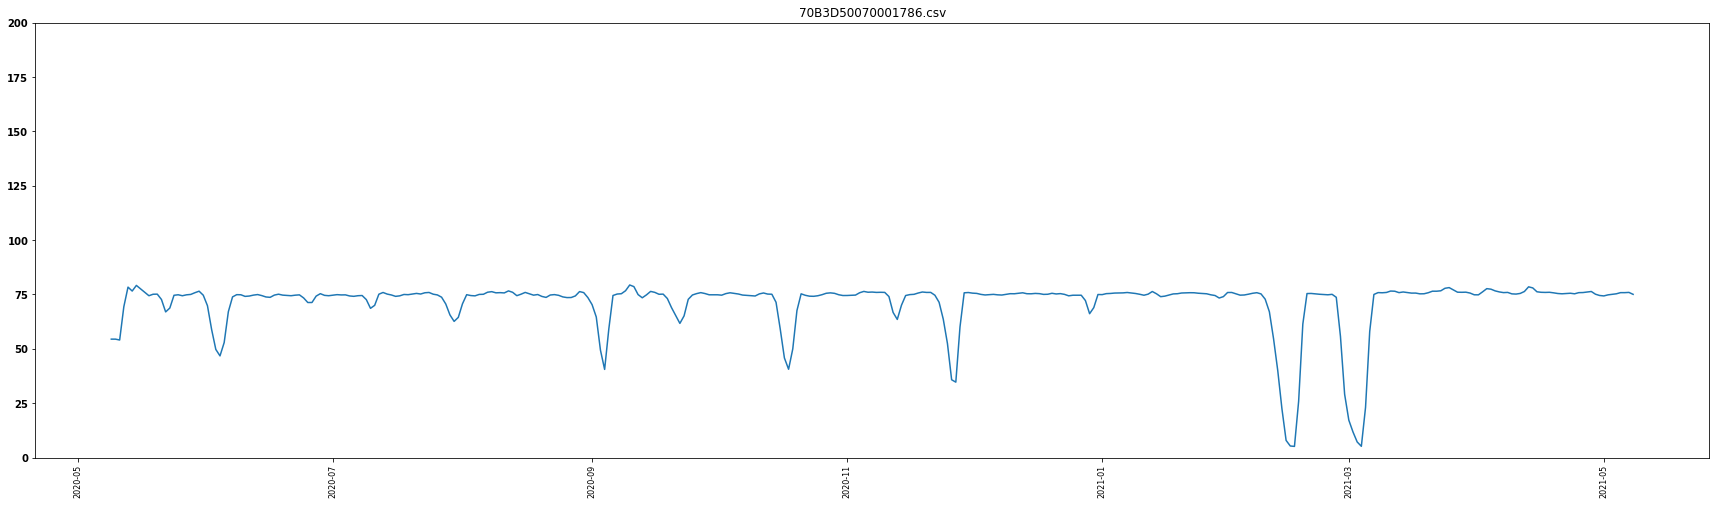

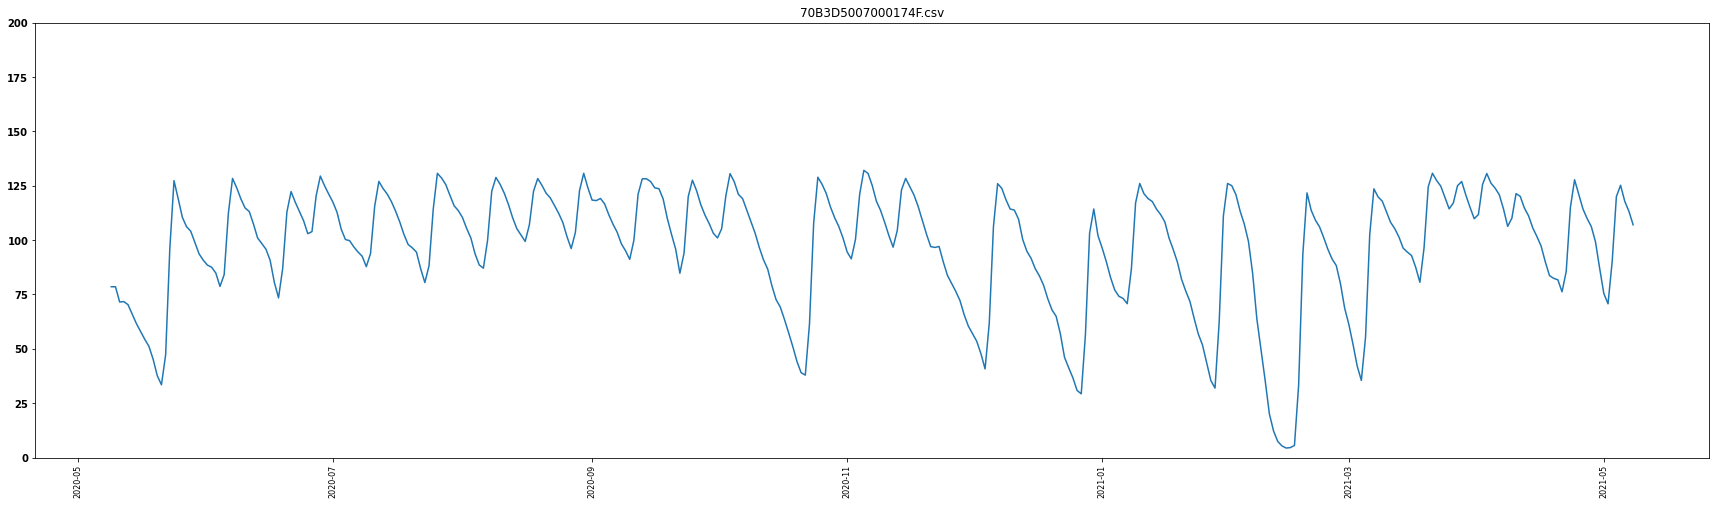

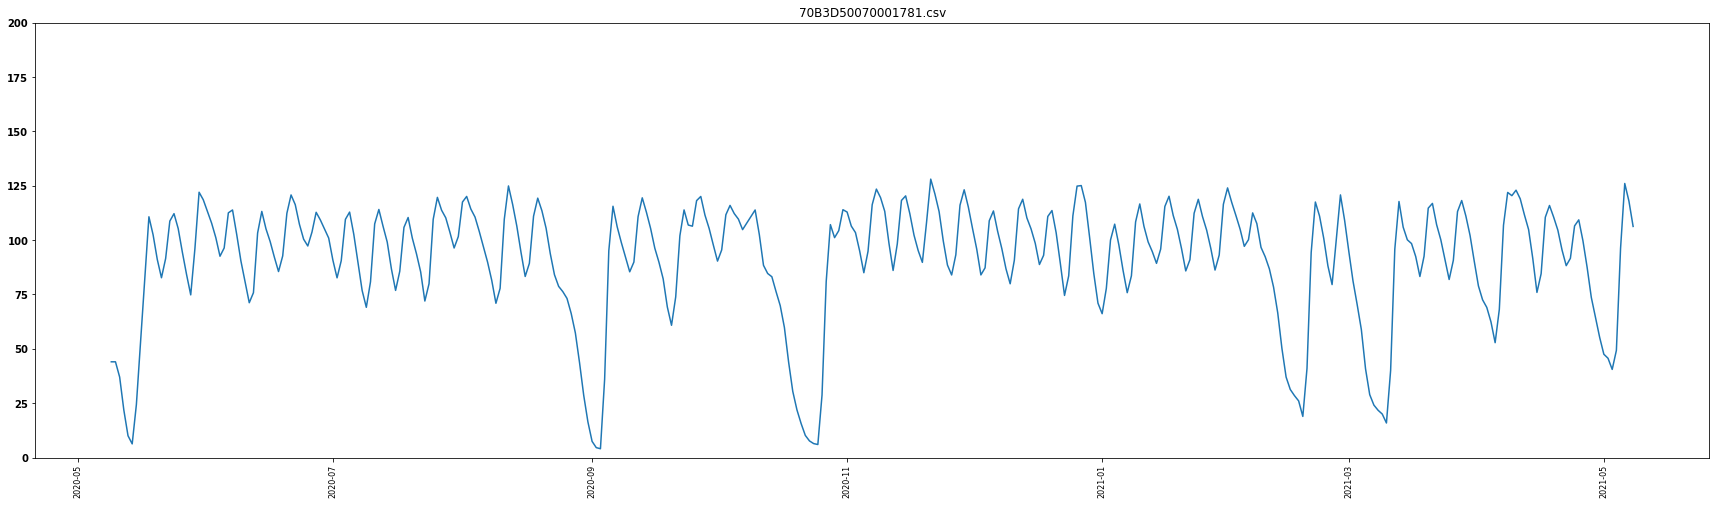

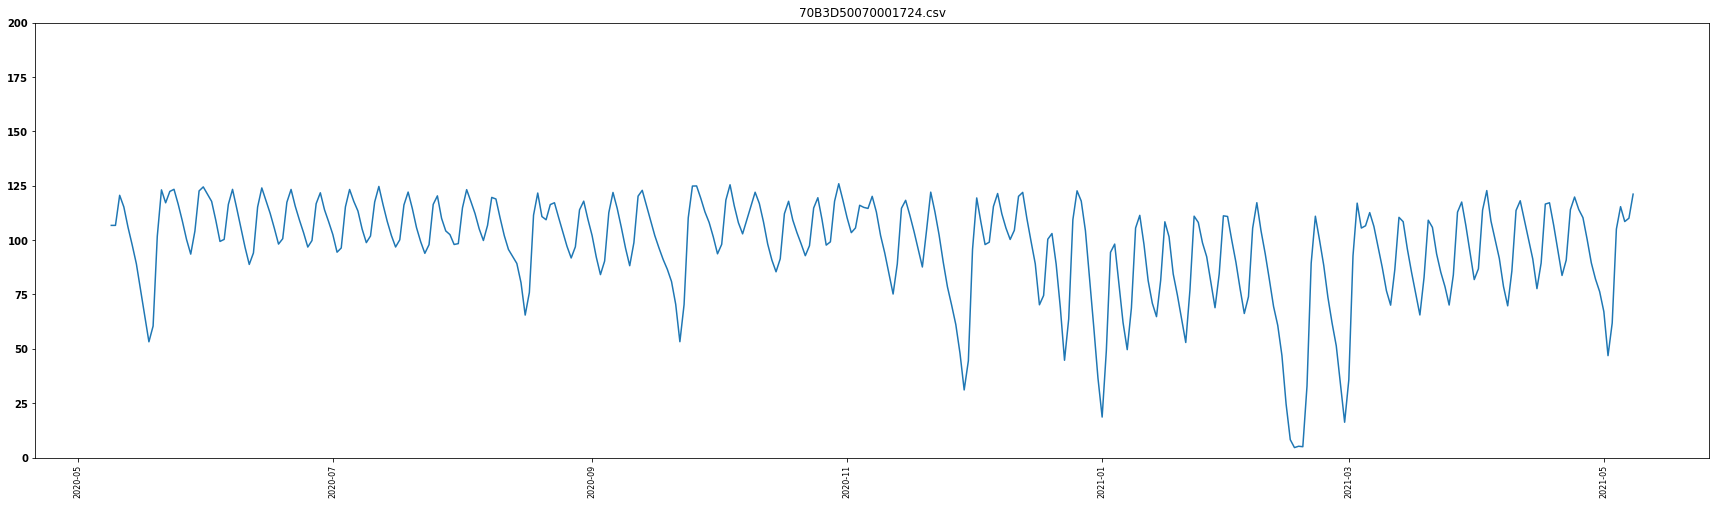

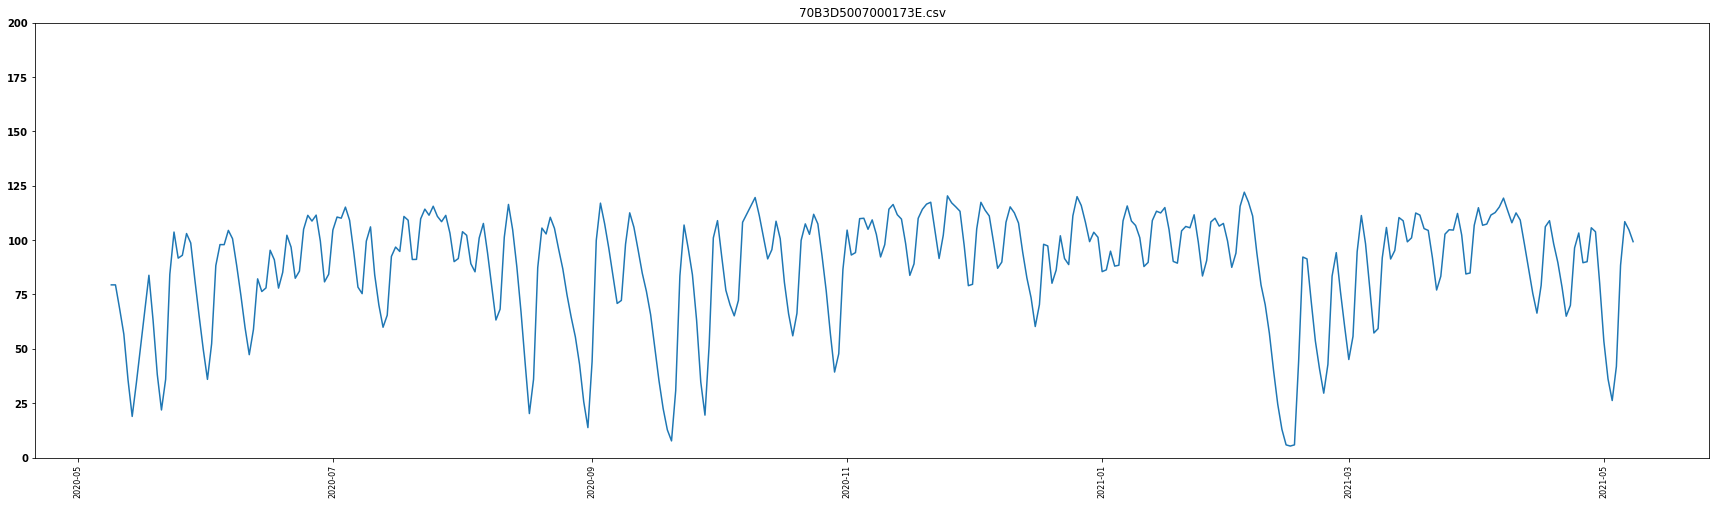

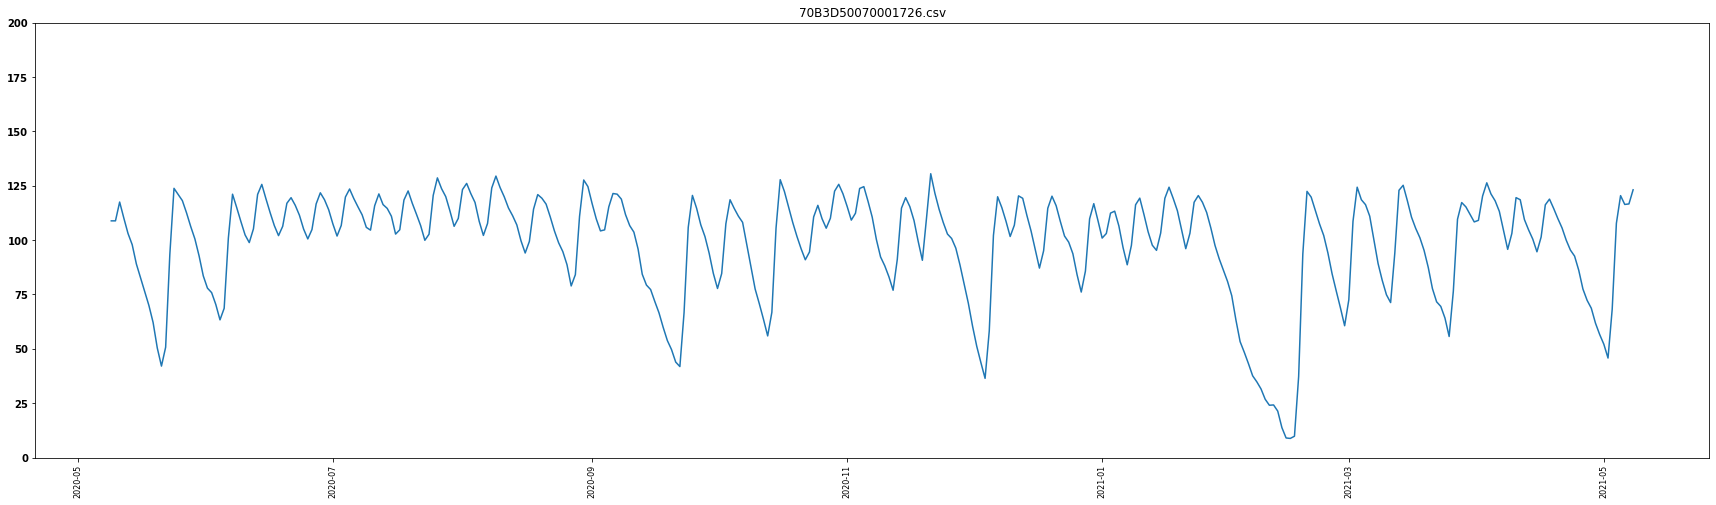

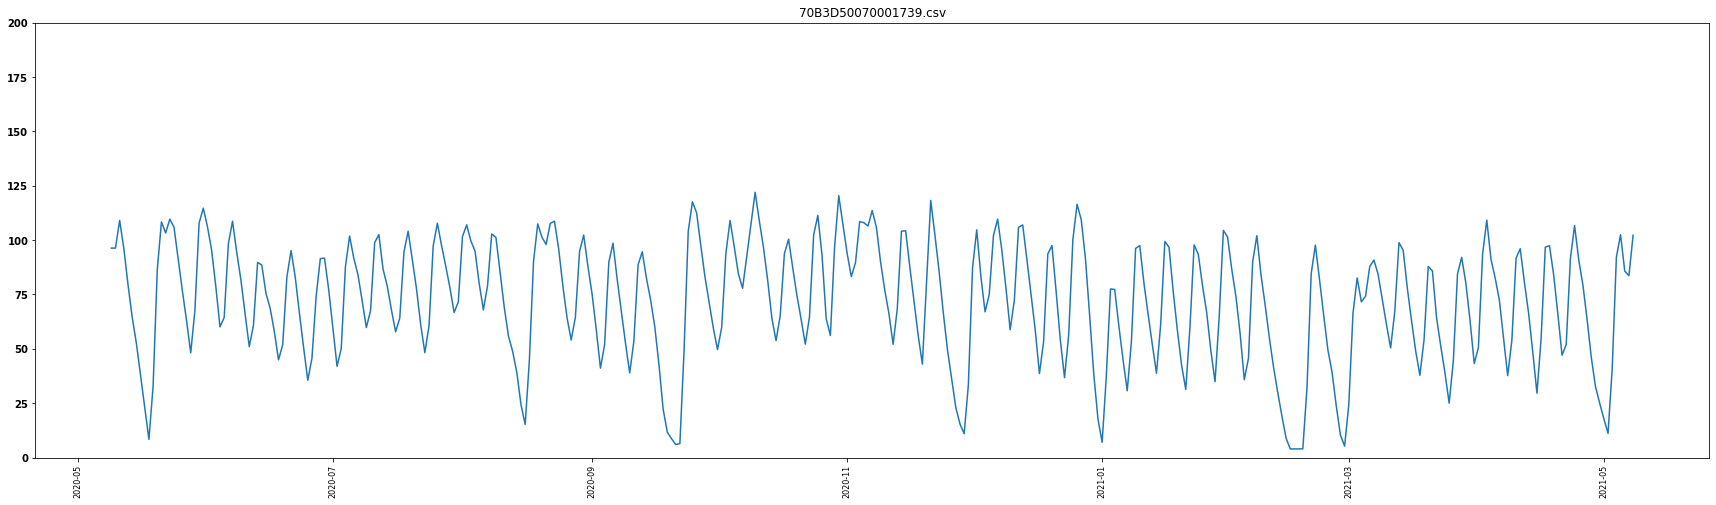

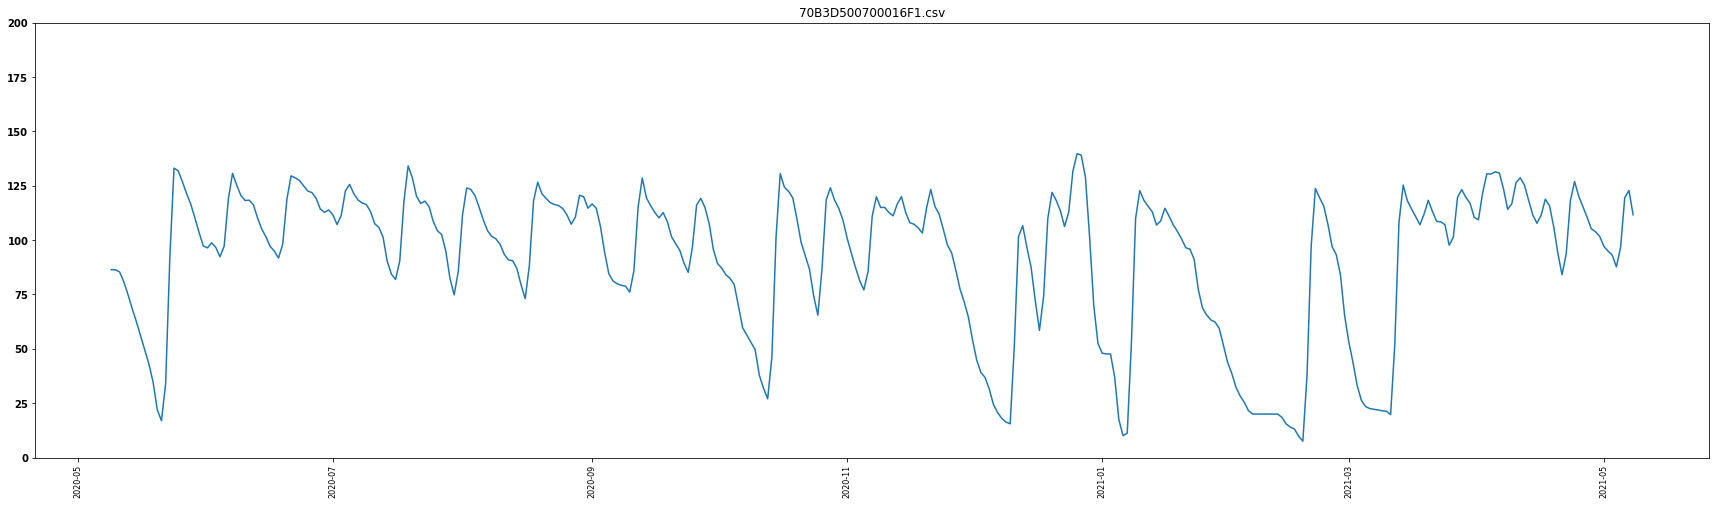

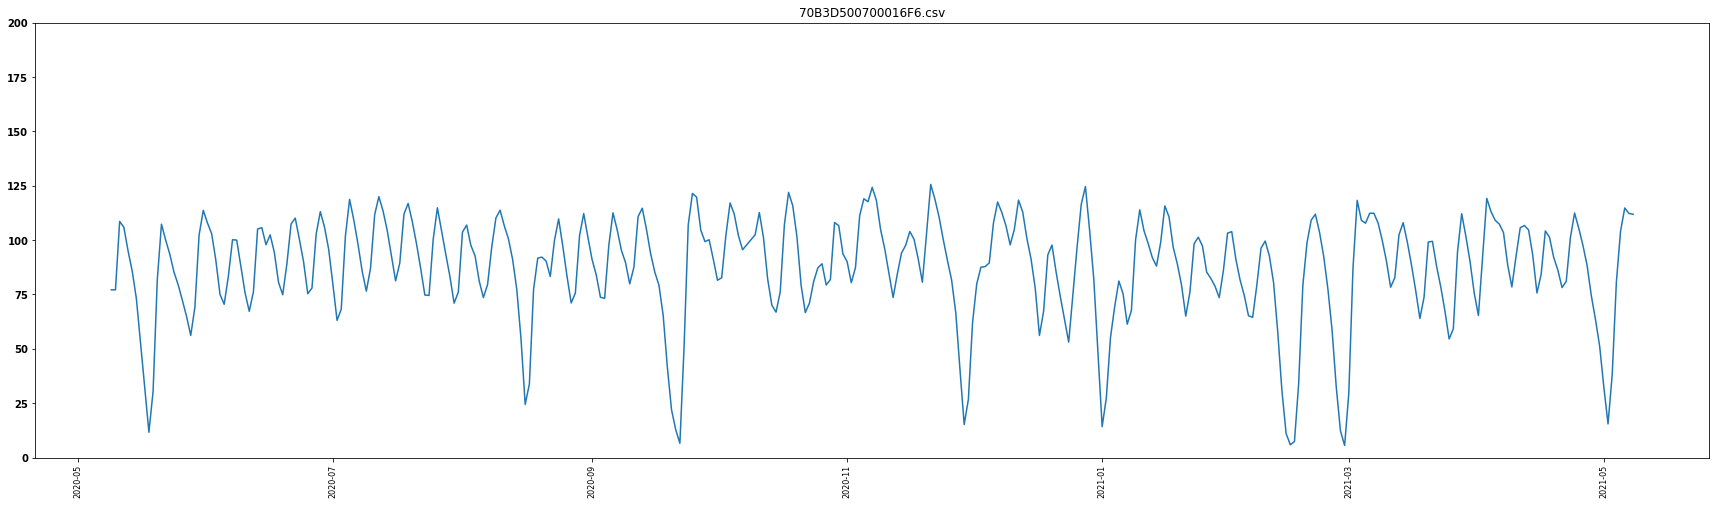

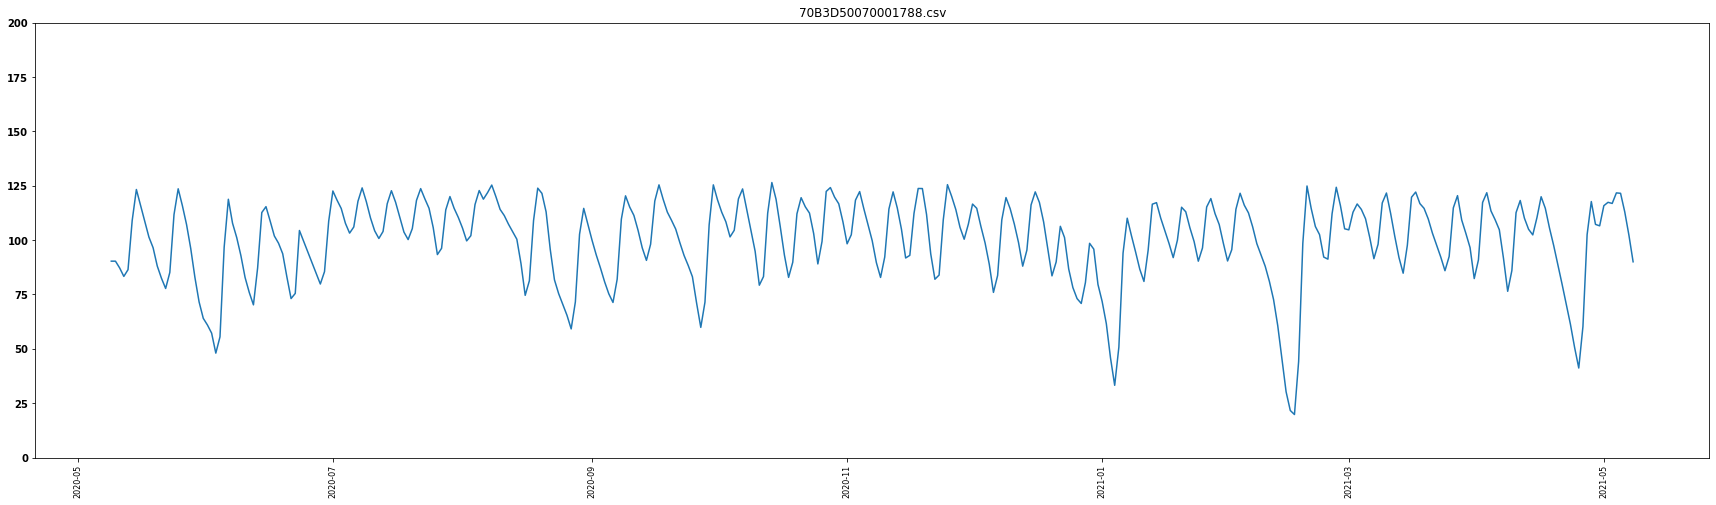

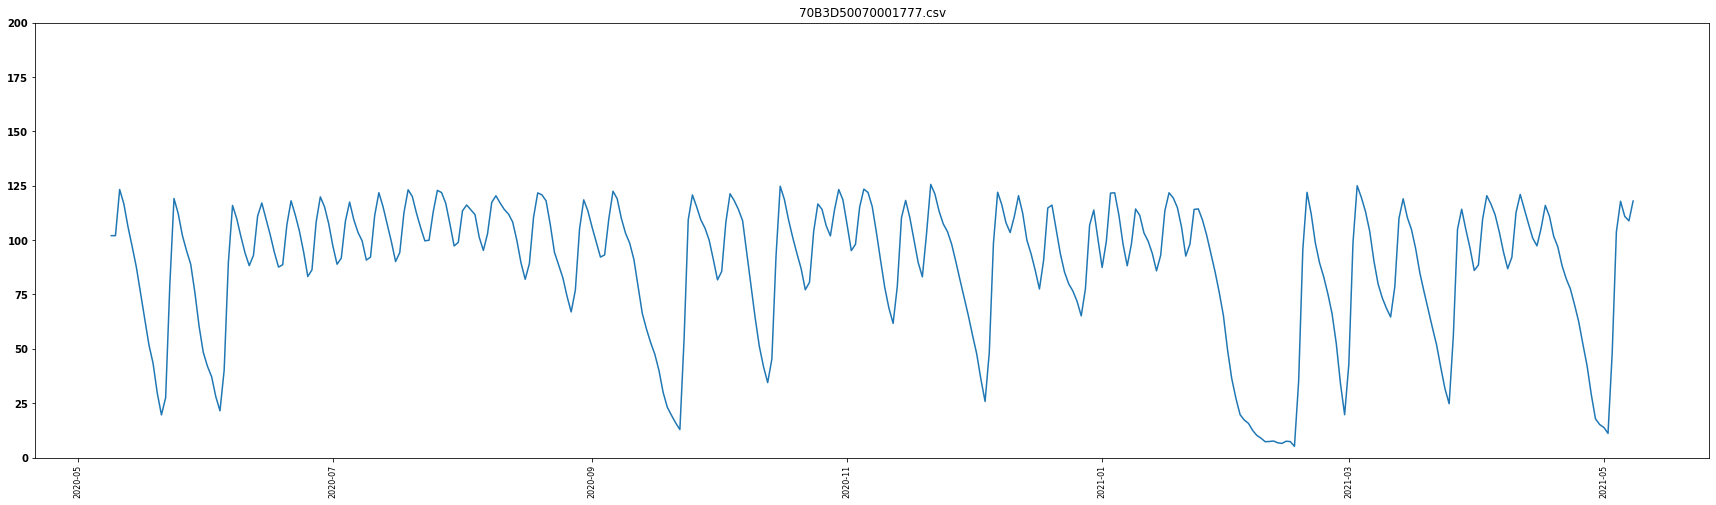

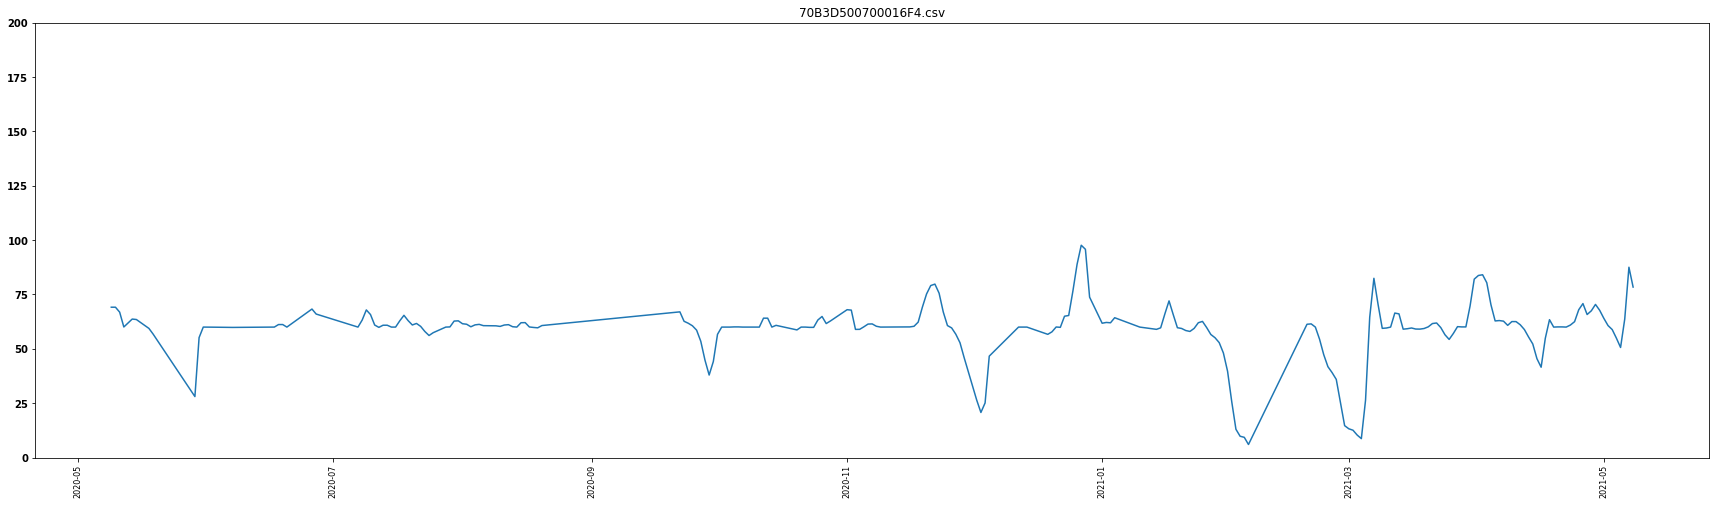

Directory  ../data/preprocessed/clusters/1  Created 
Cluster 1


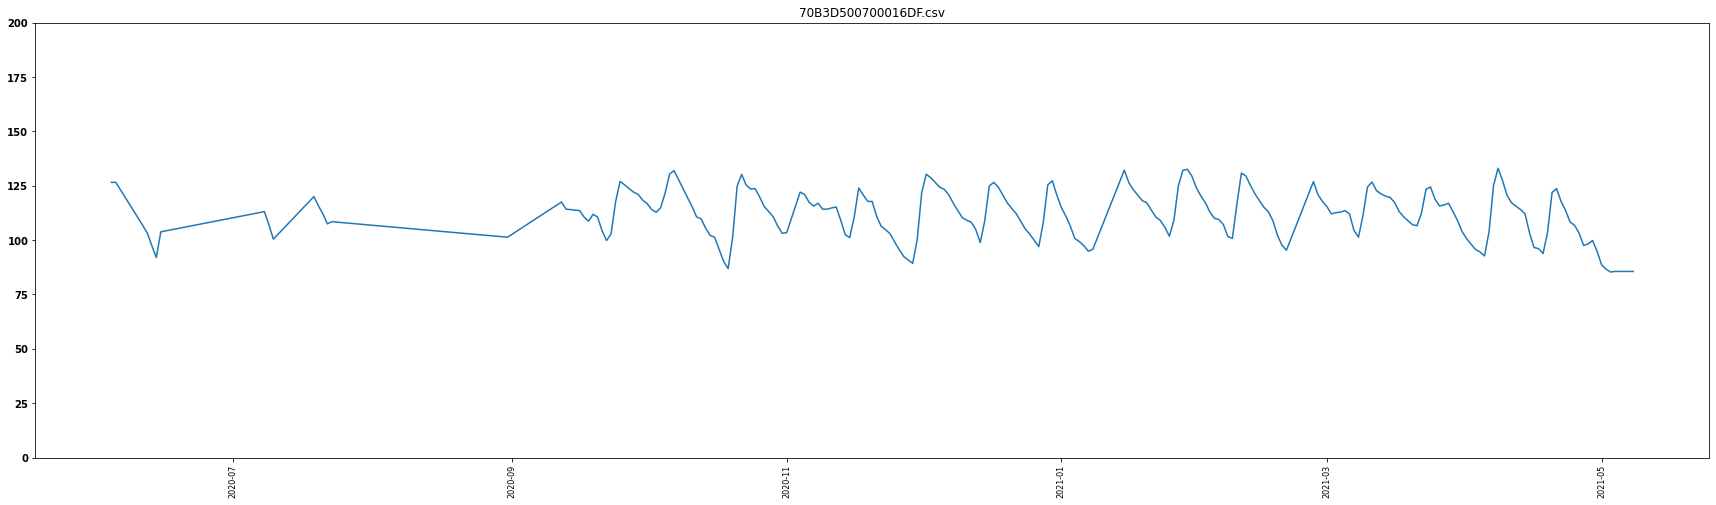

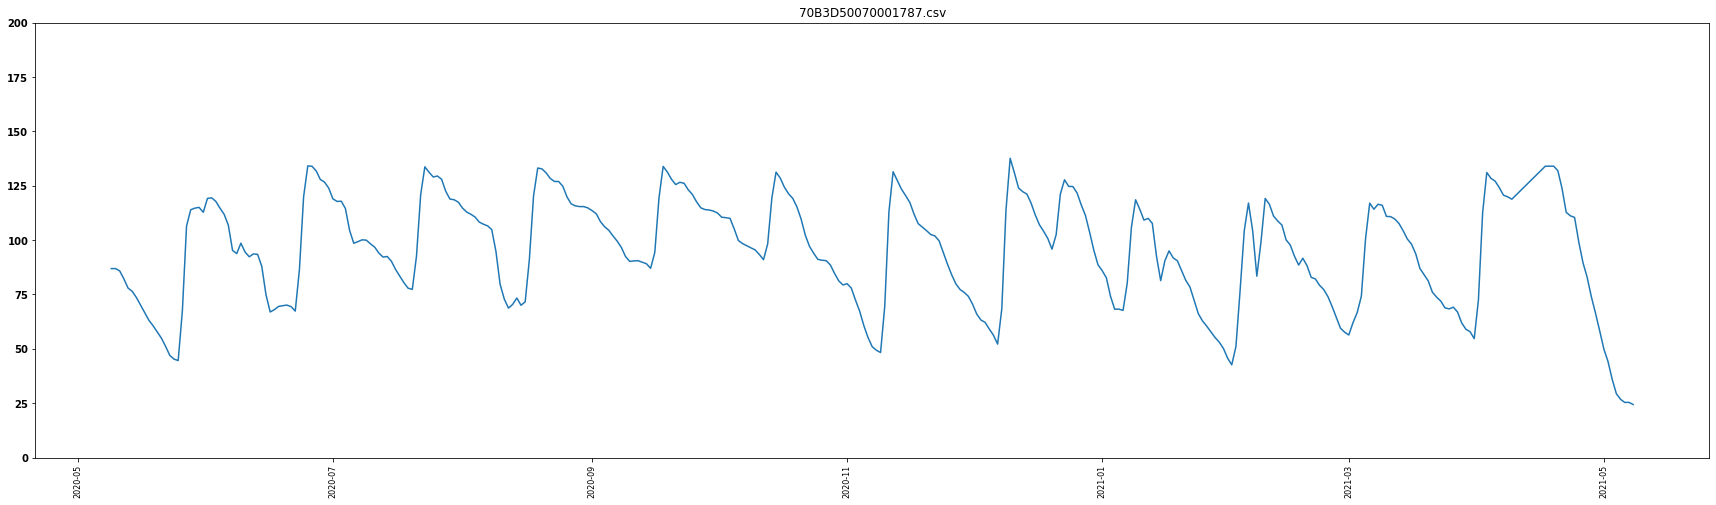

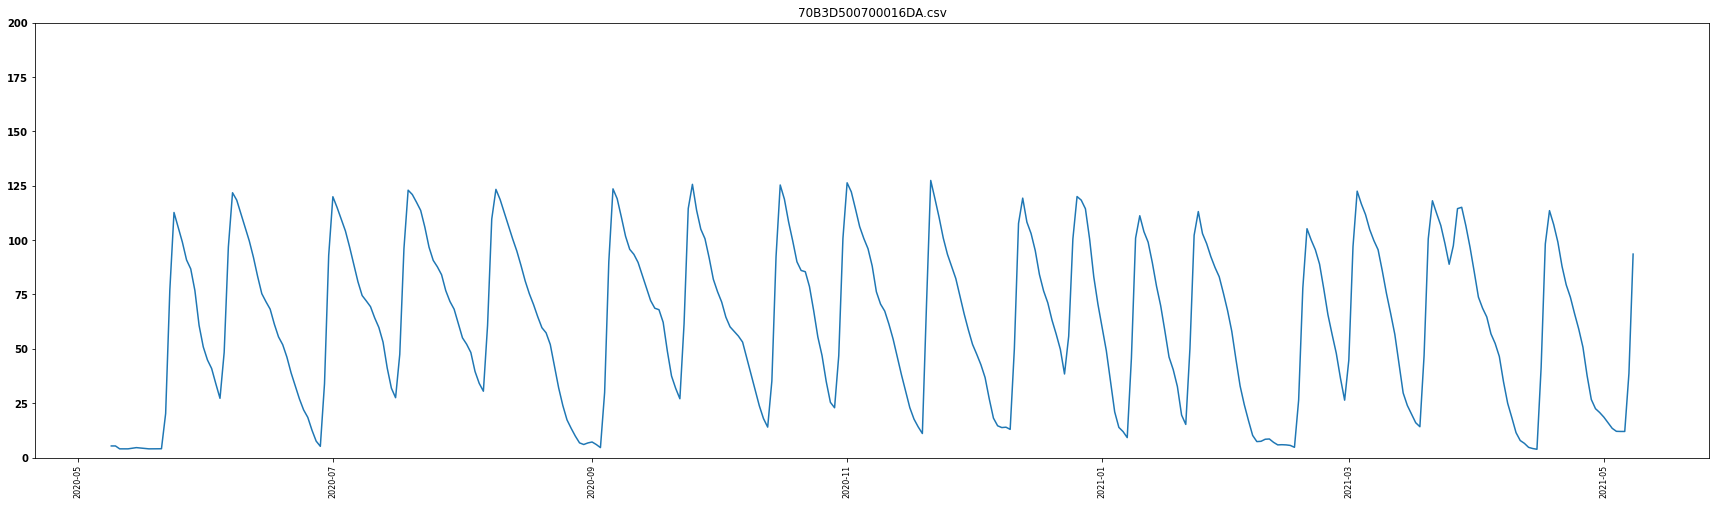

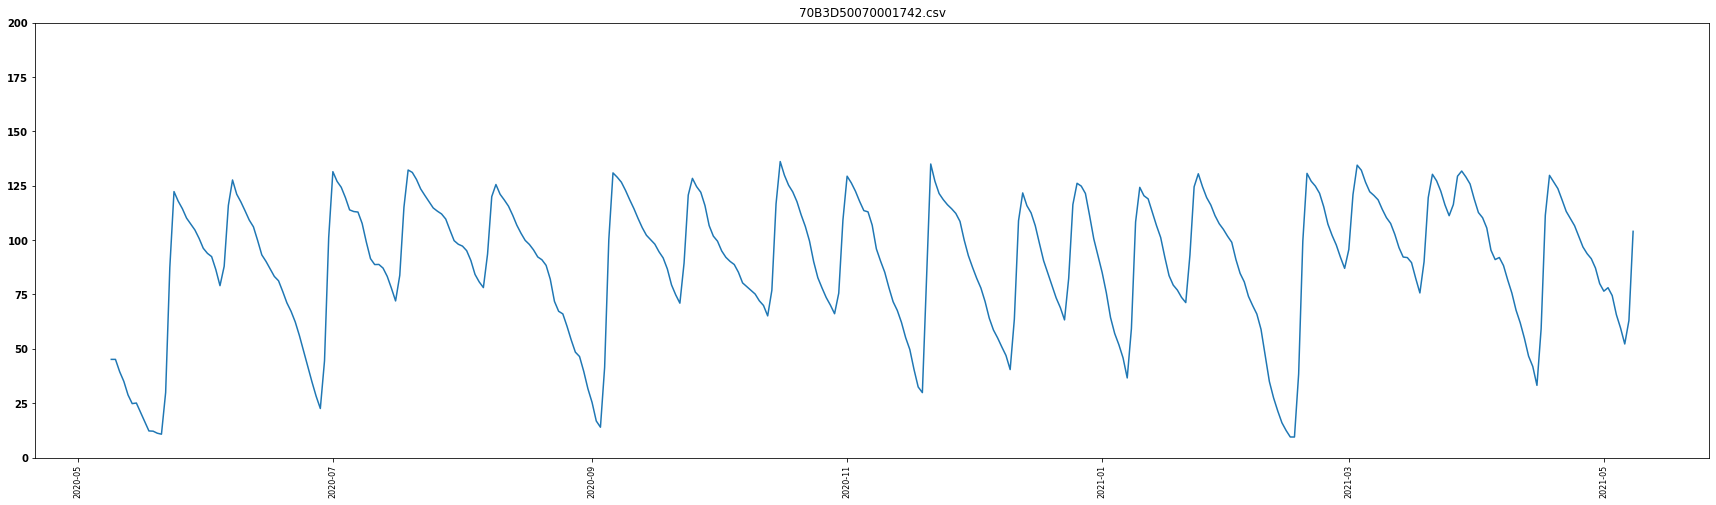

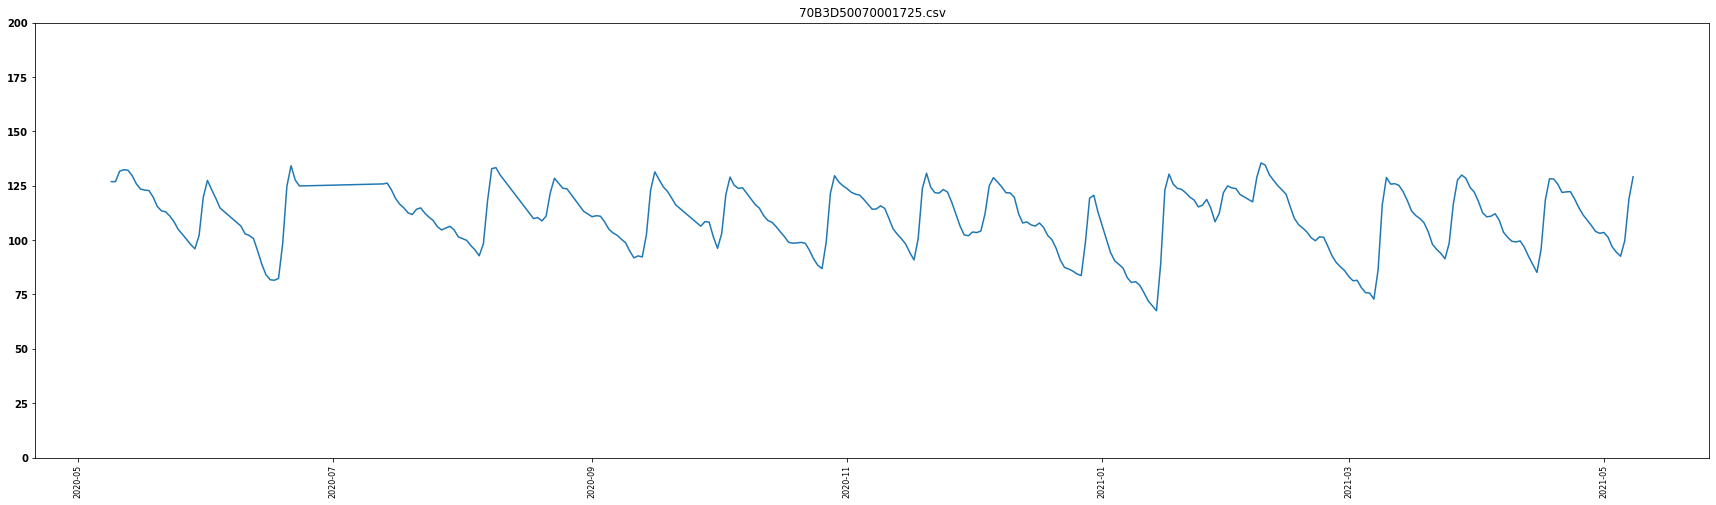

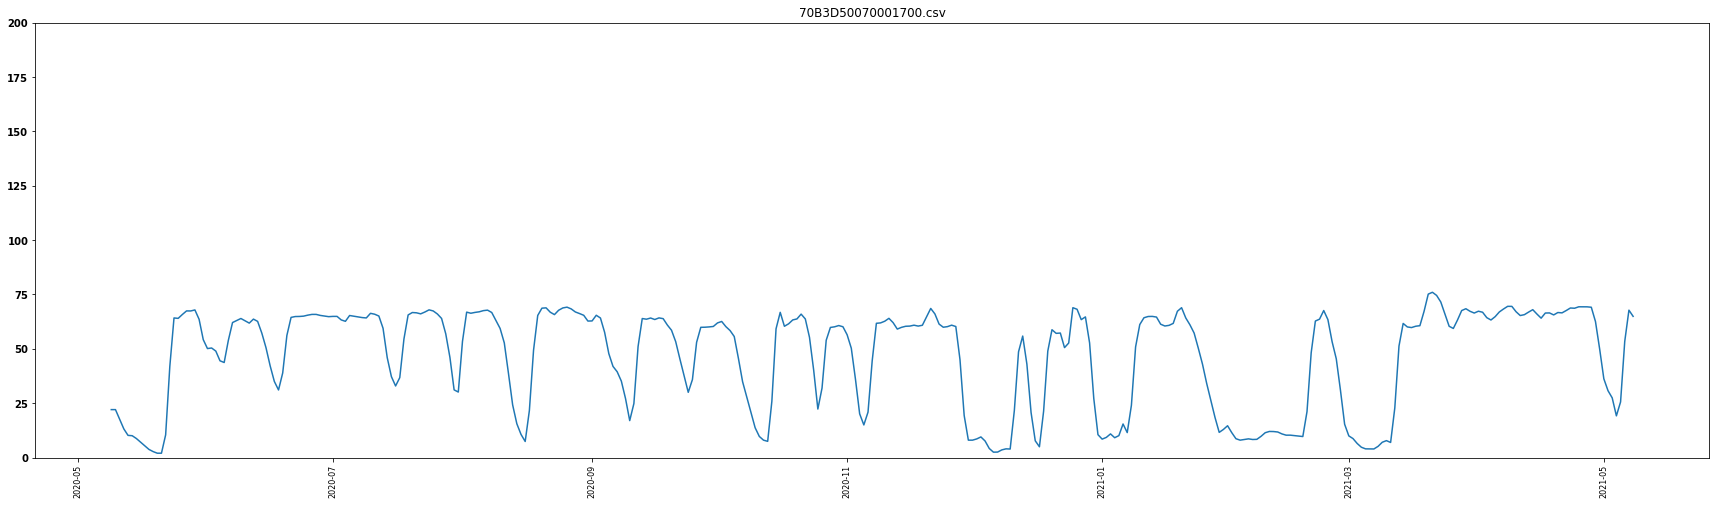

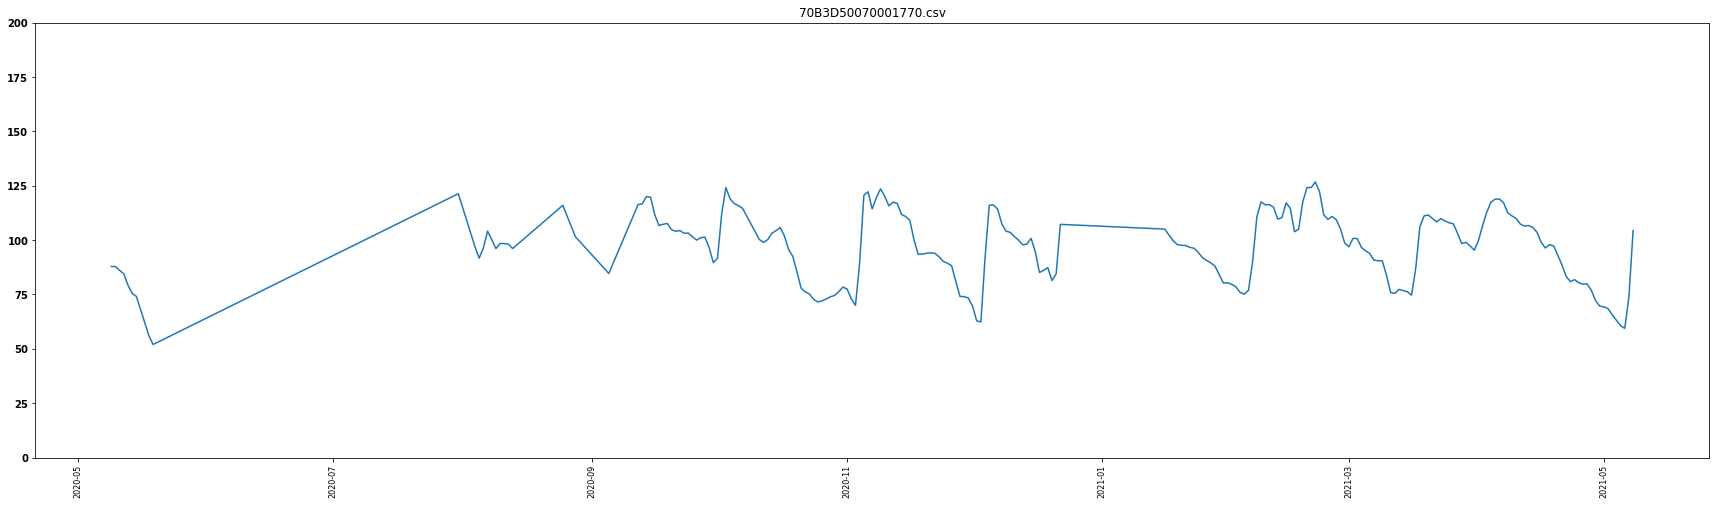

Directory  ../data/preprocessed/clusters/2  Created 
Cluster 2


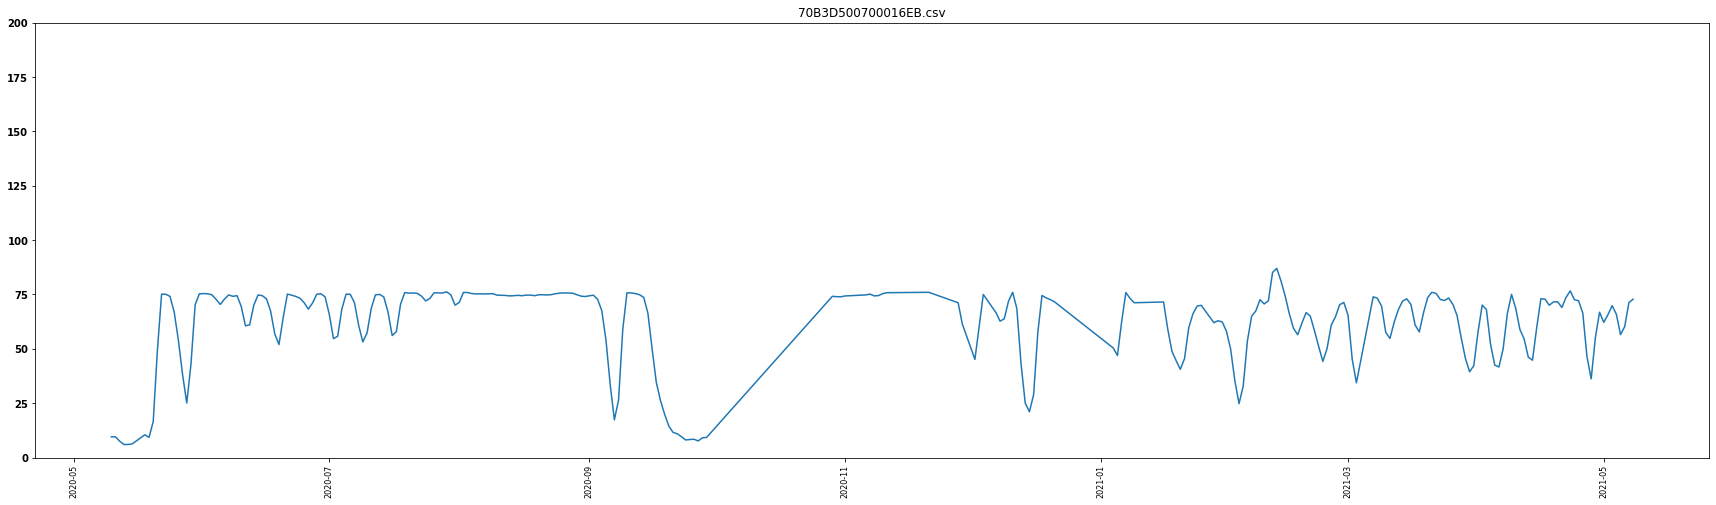

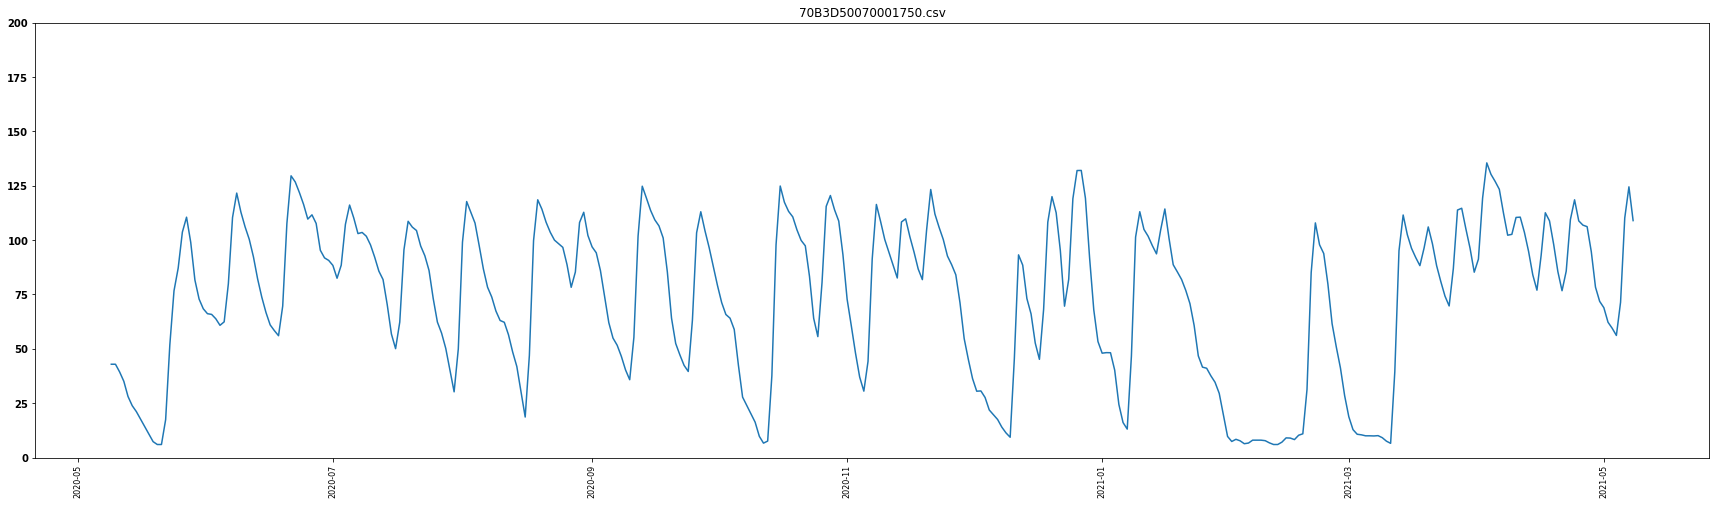

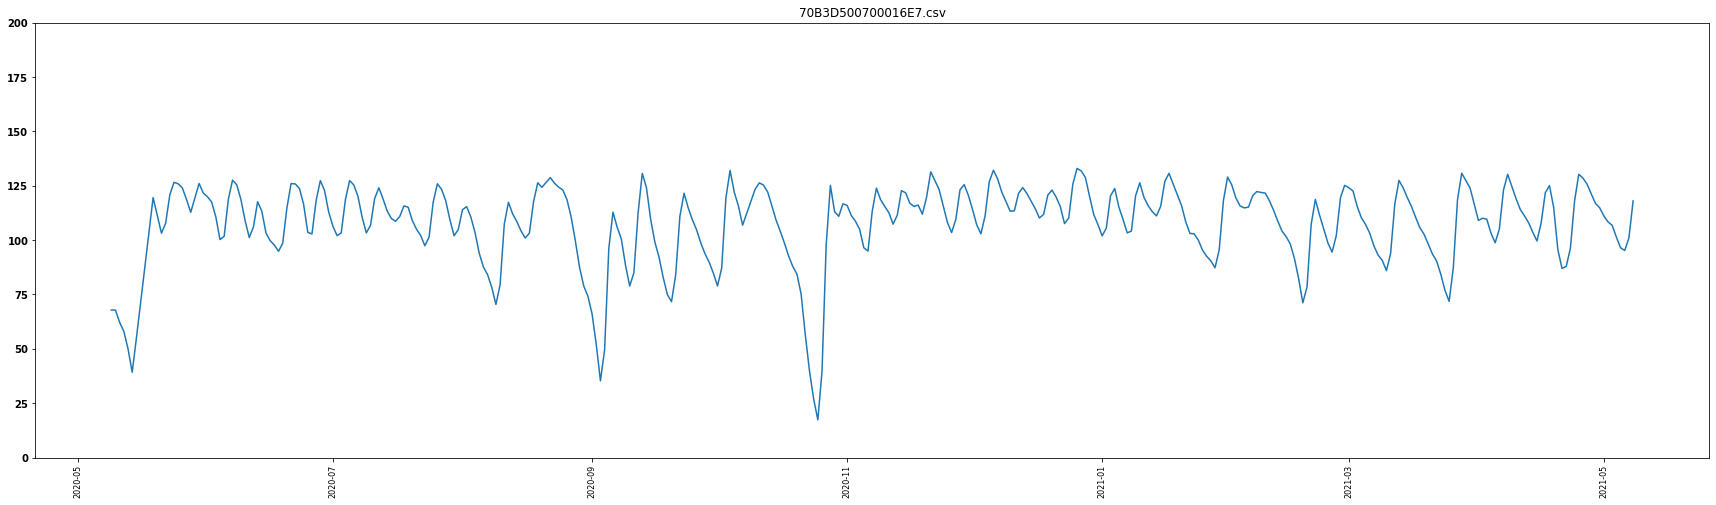

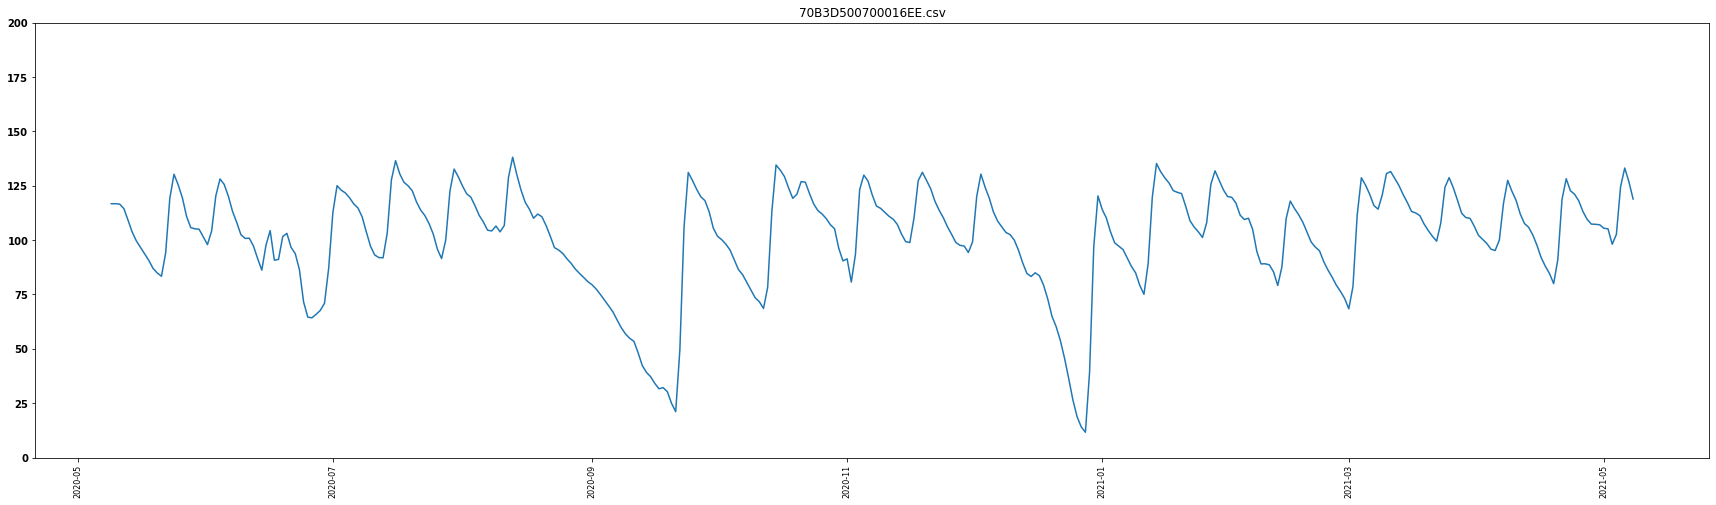

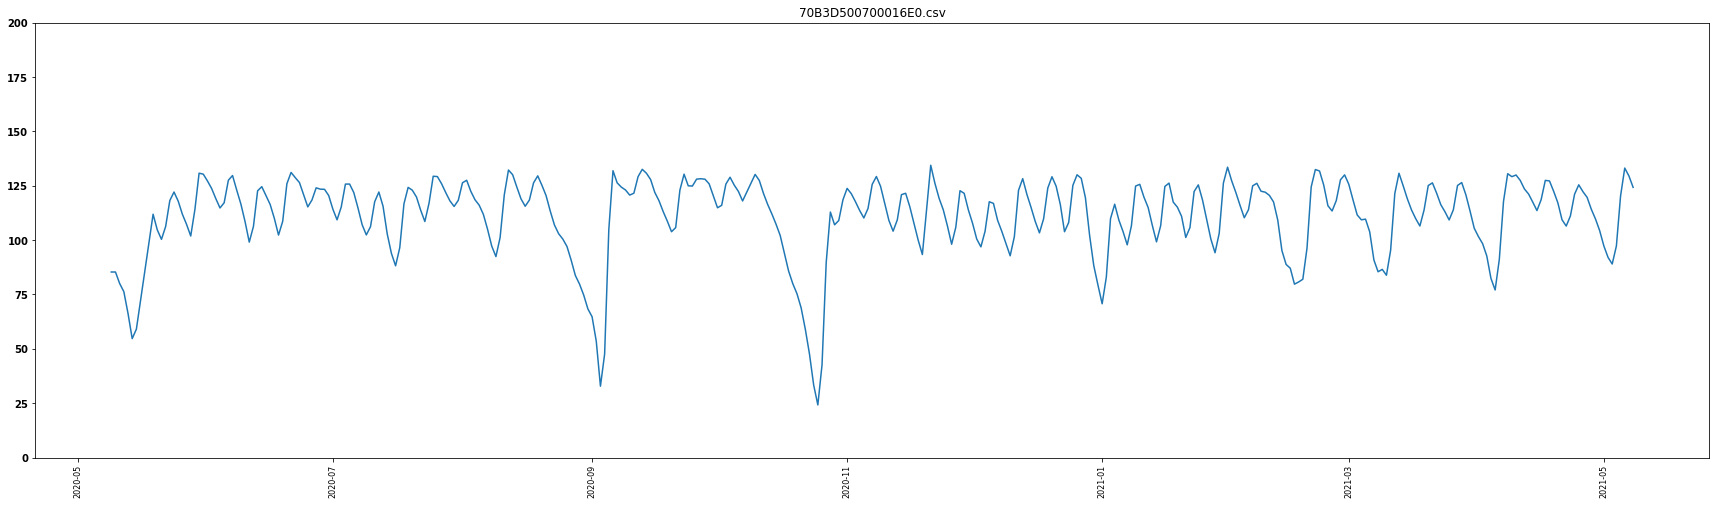

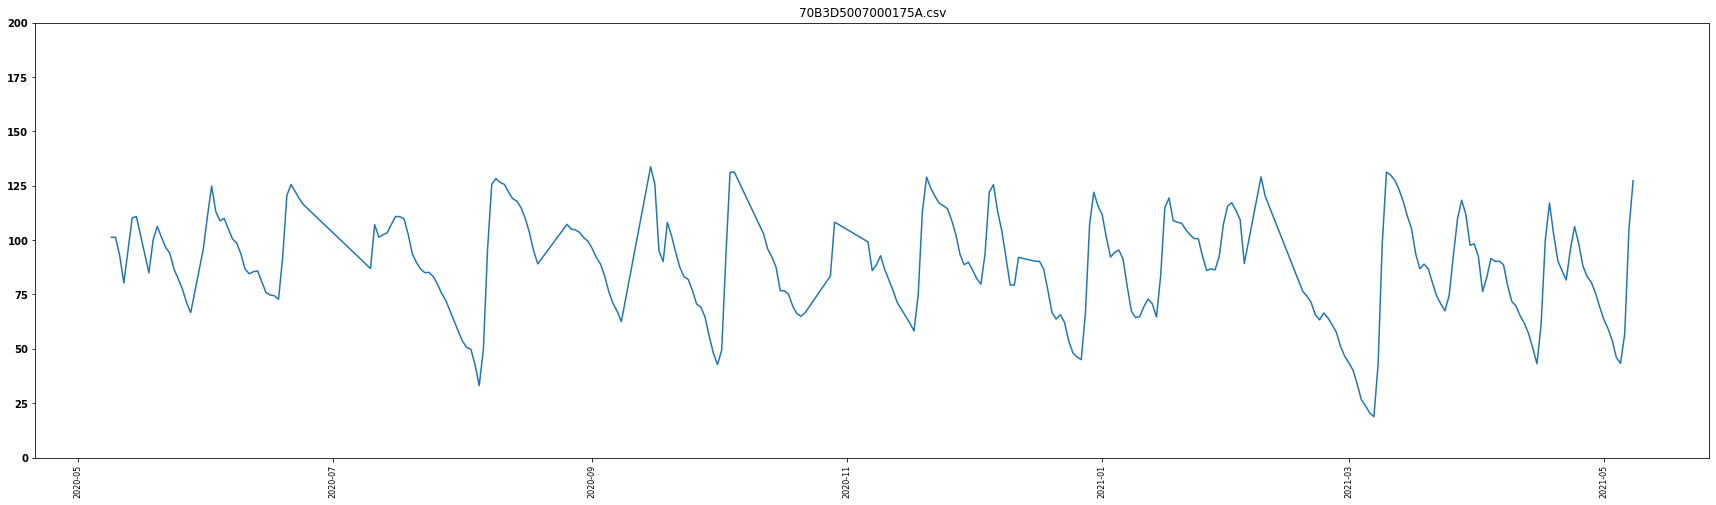

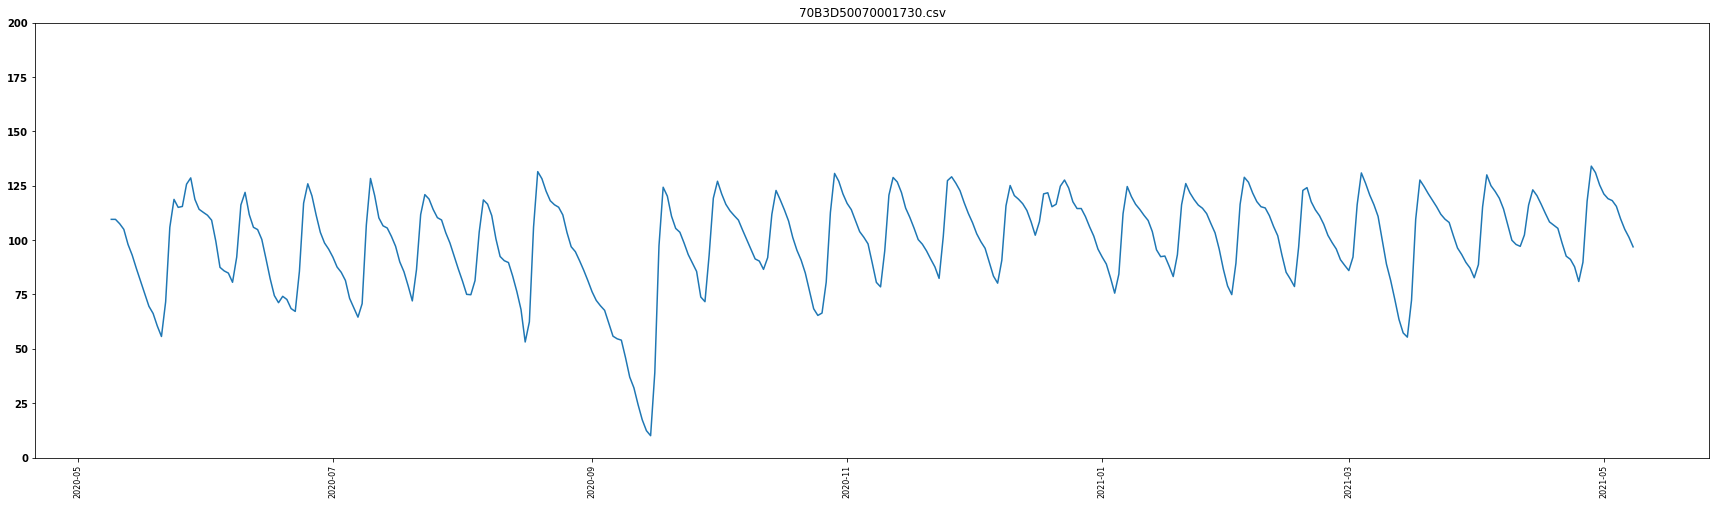

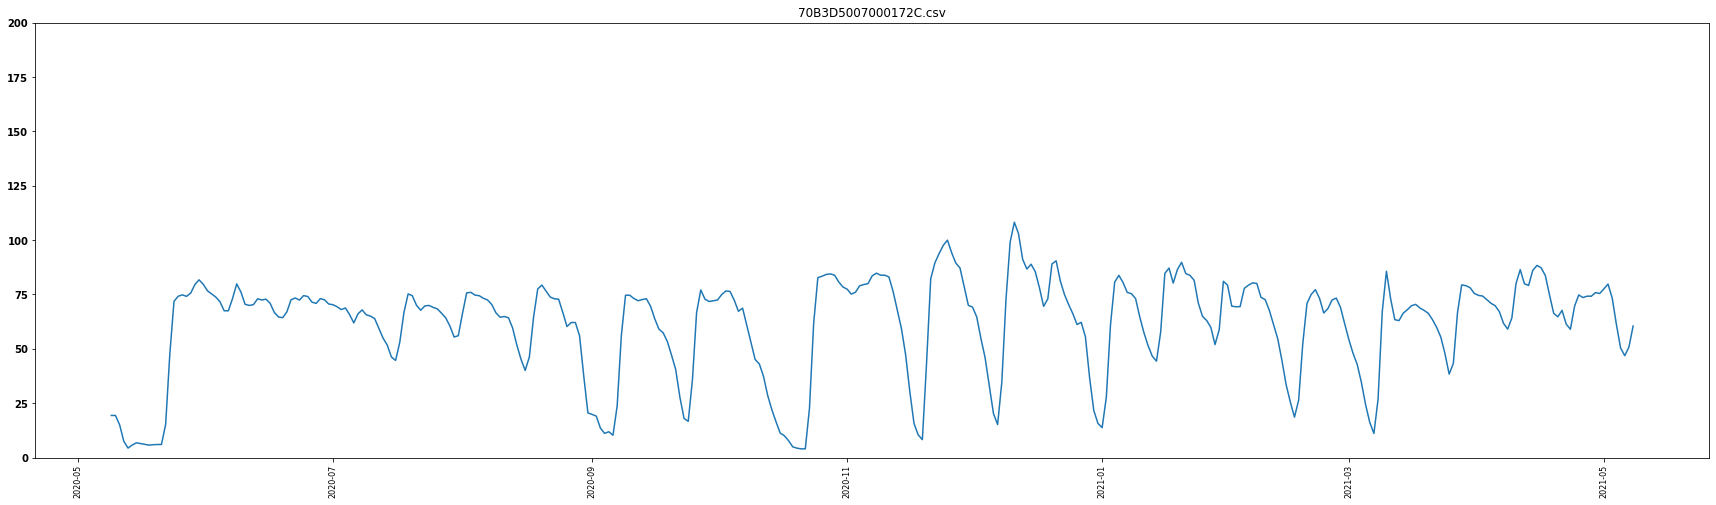

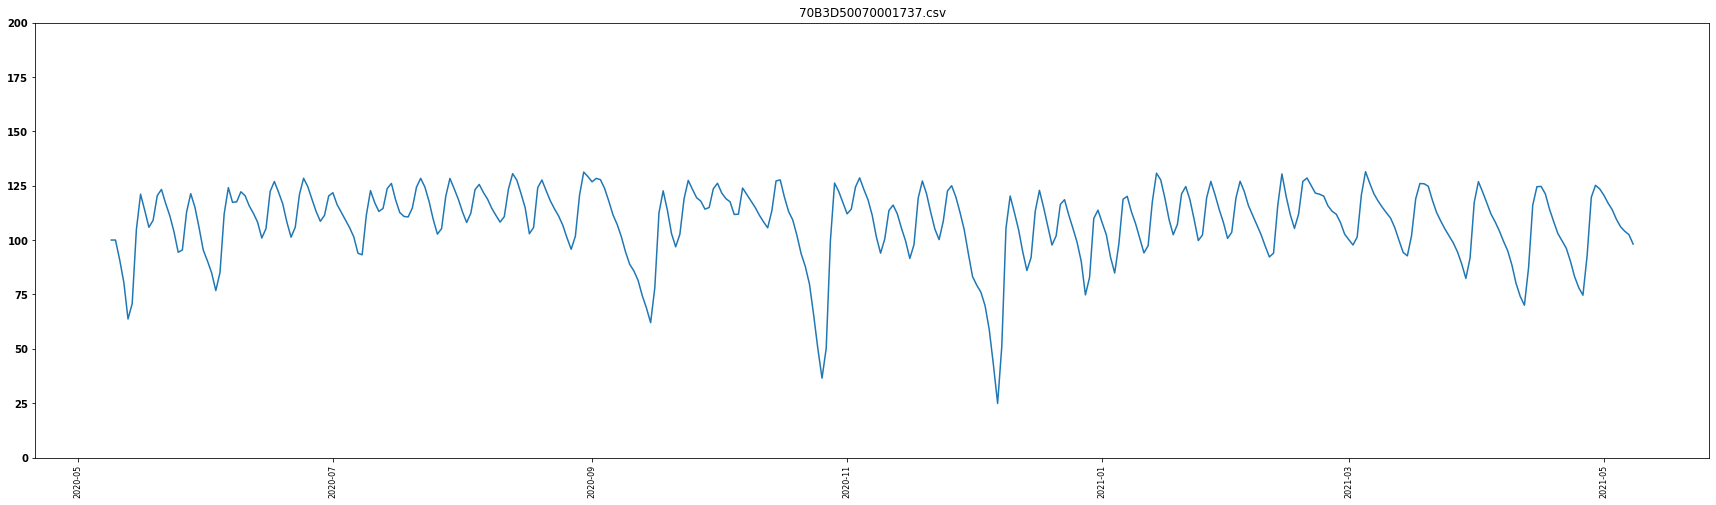

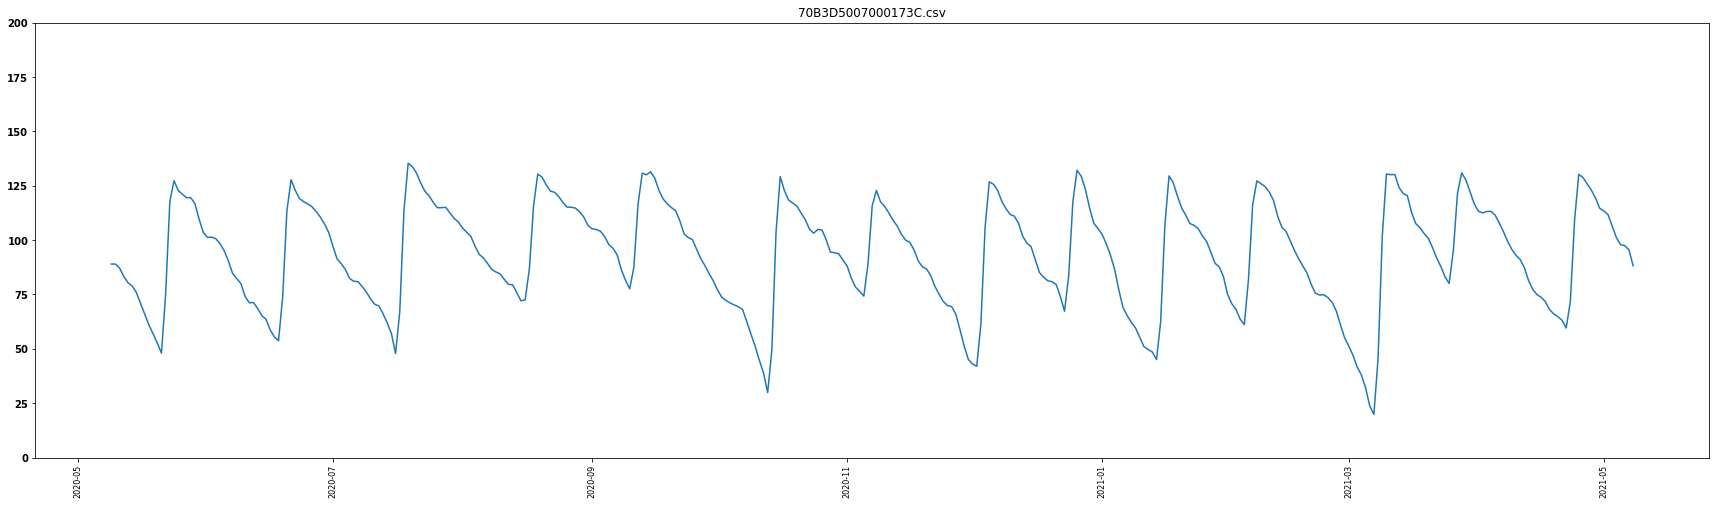

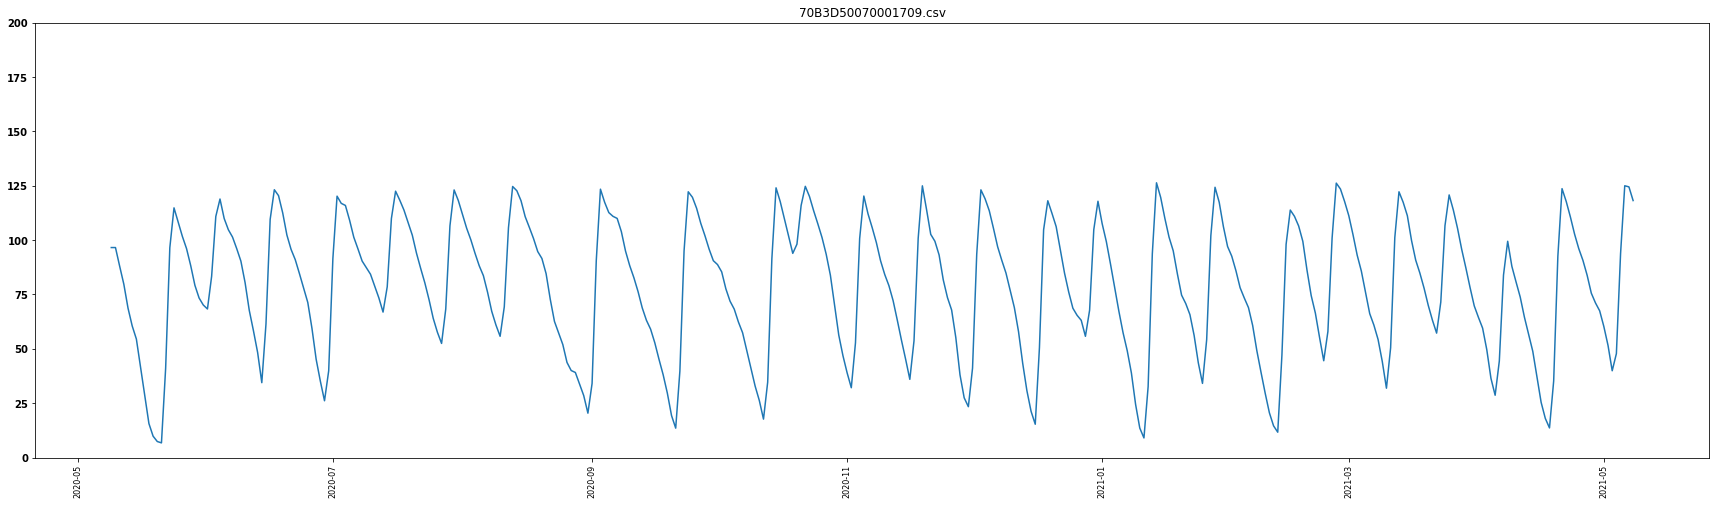

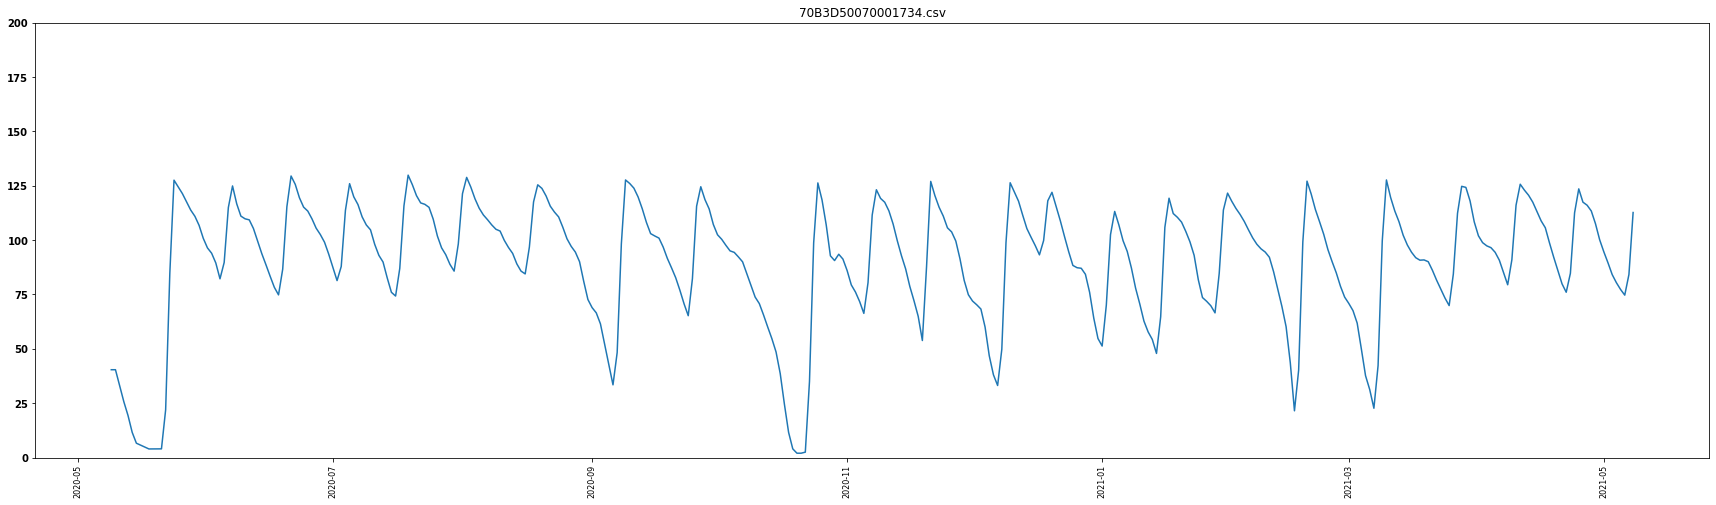

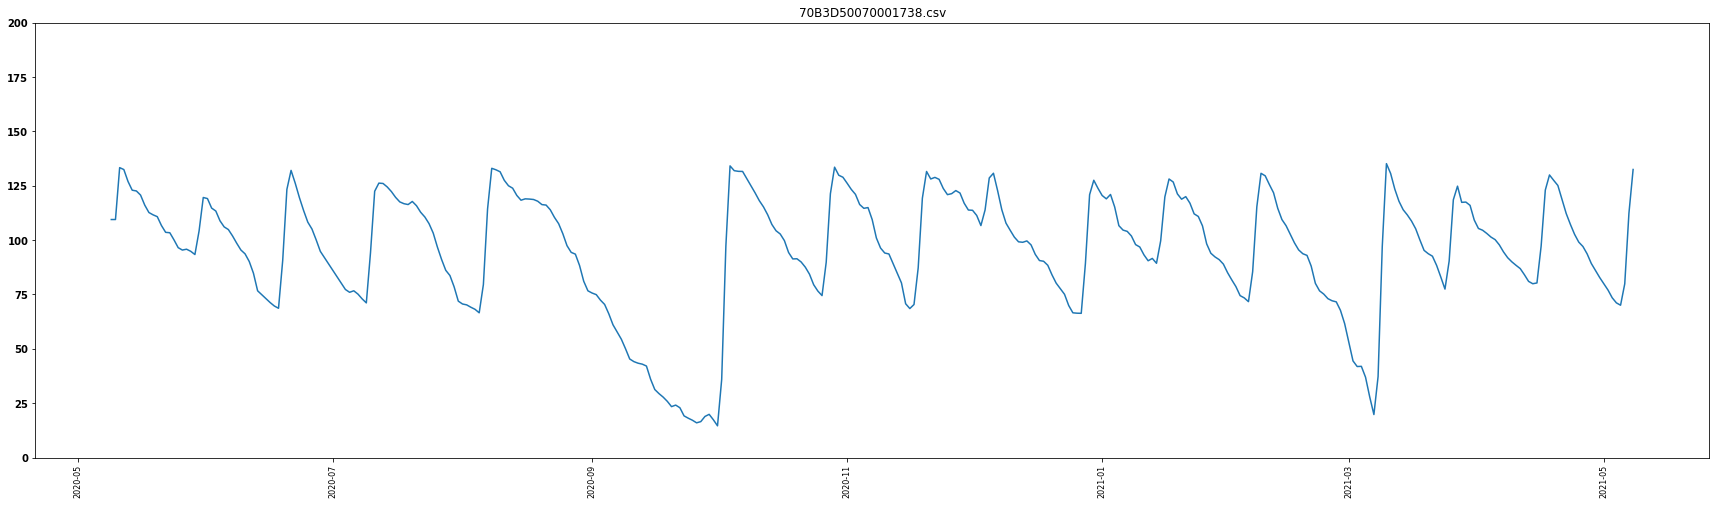

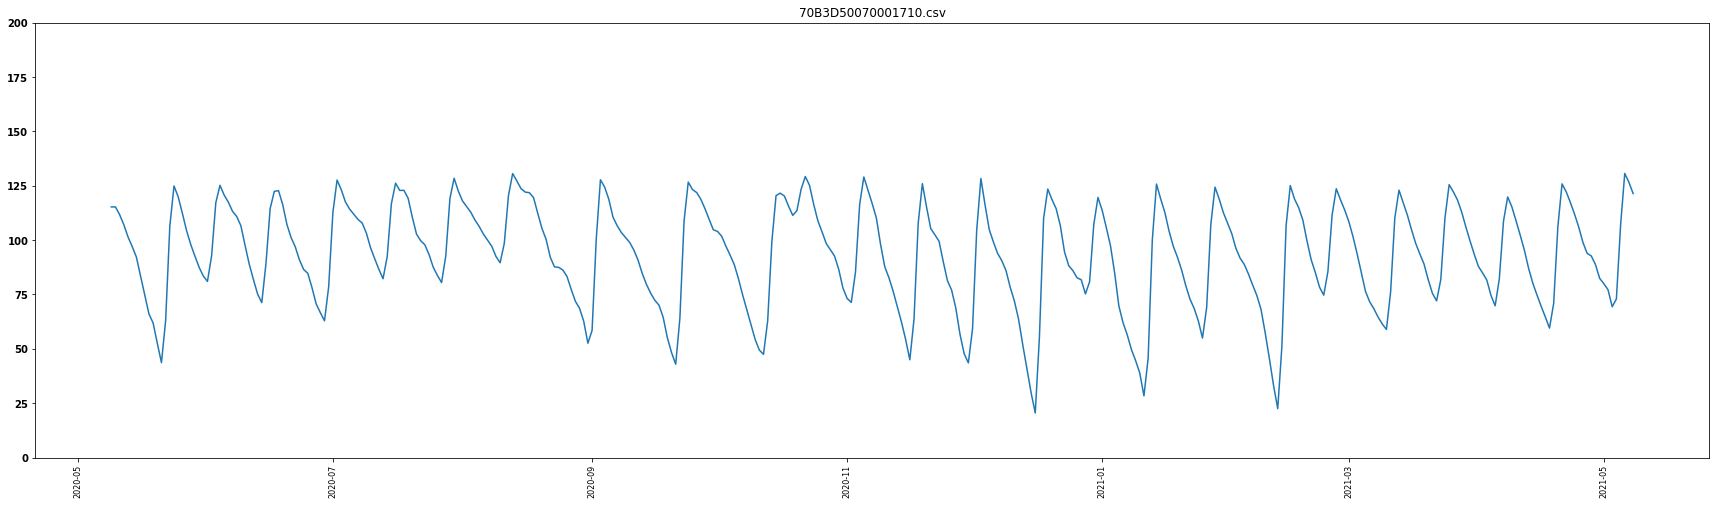

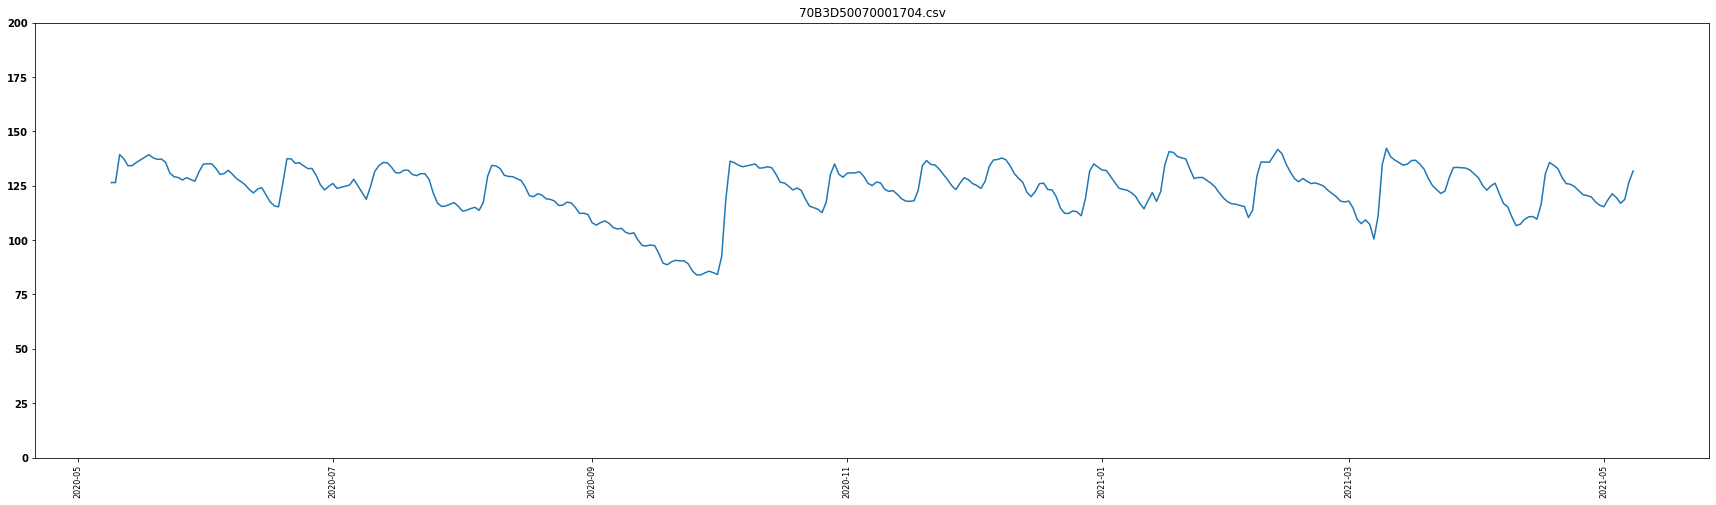

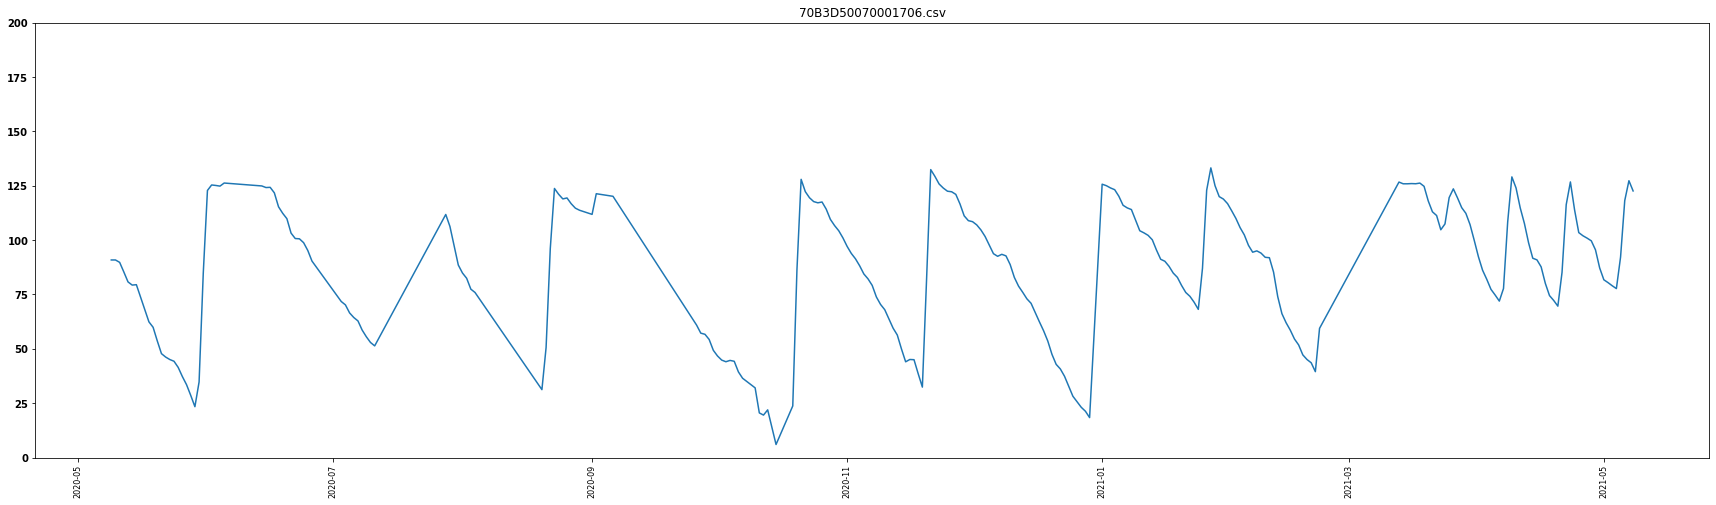

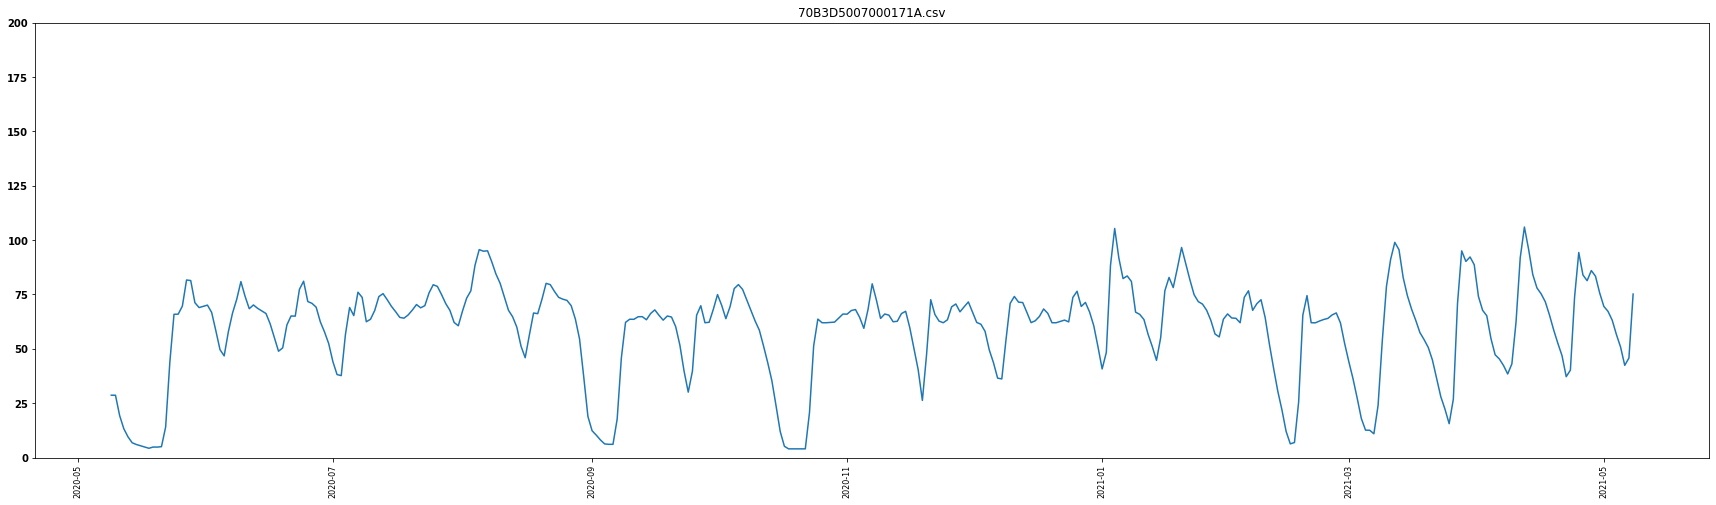

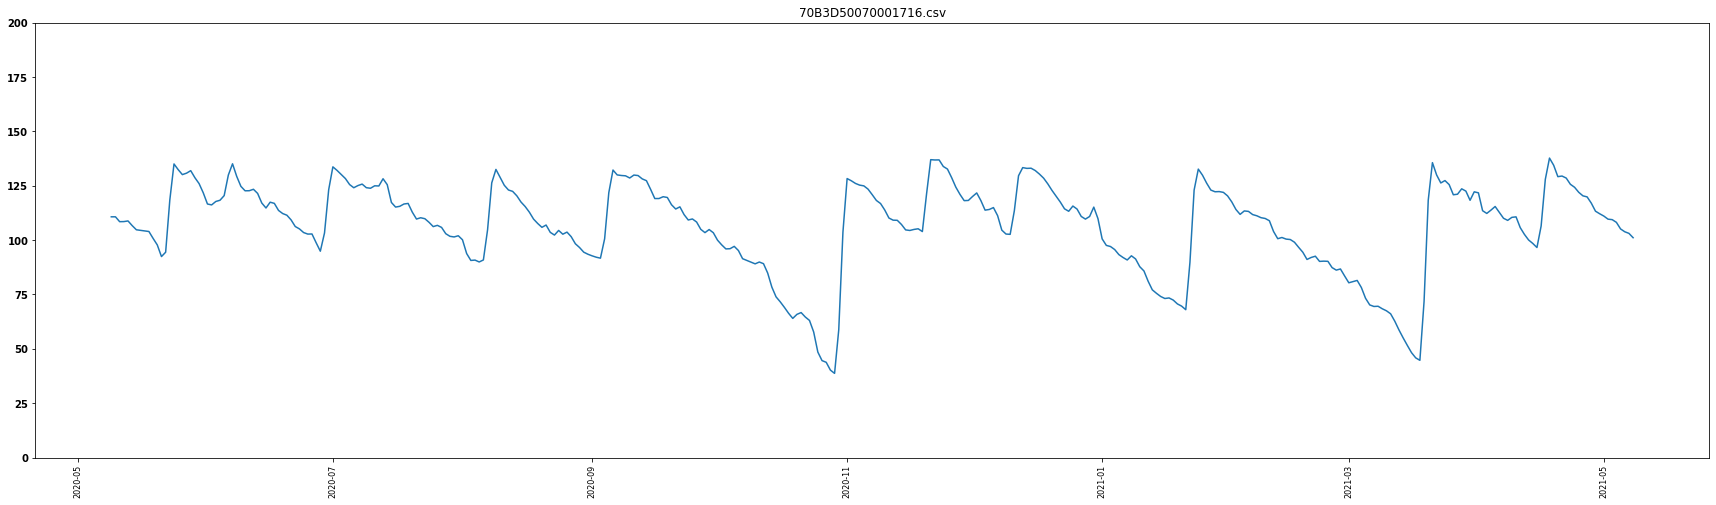

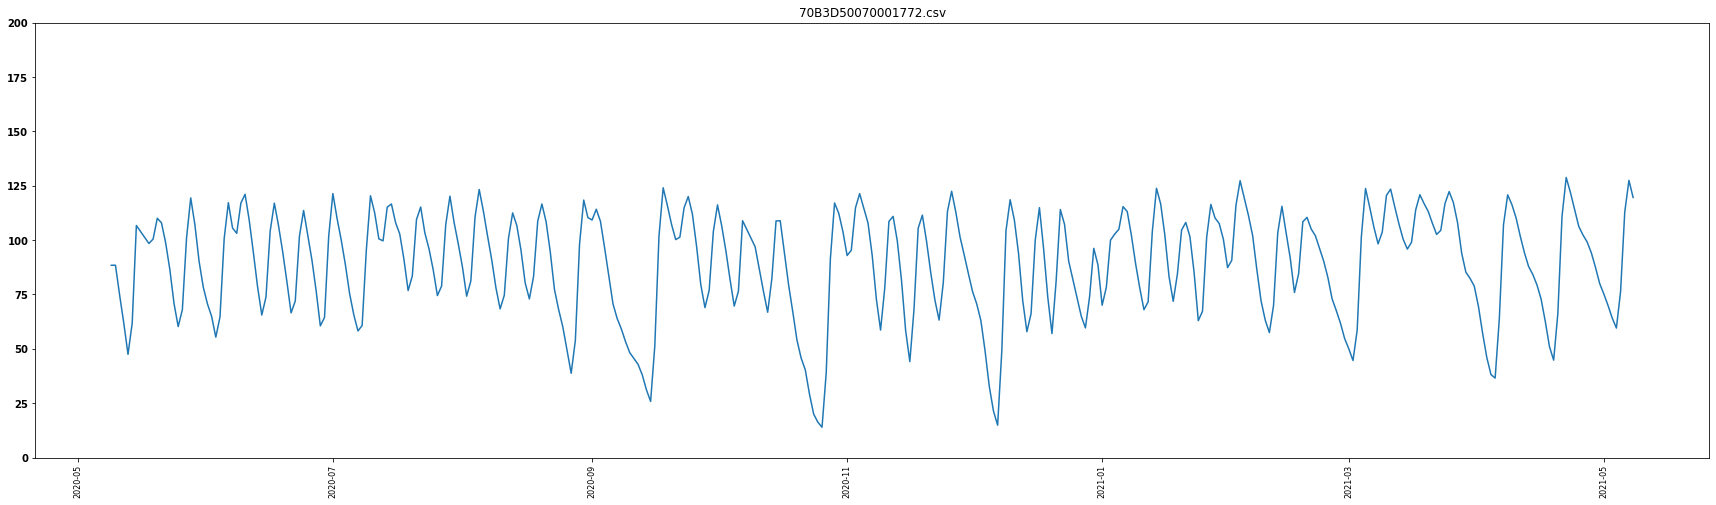

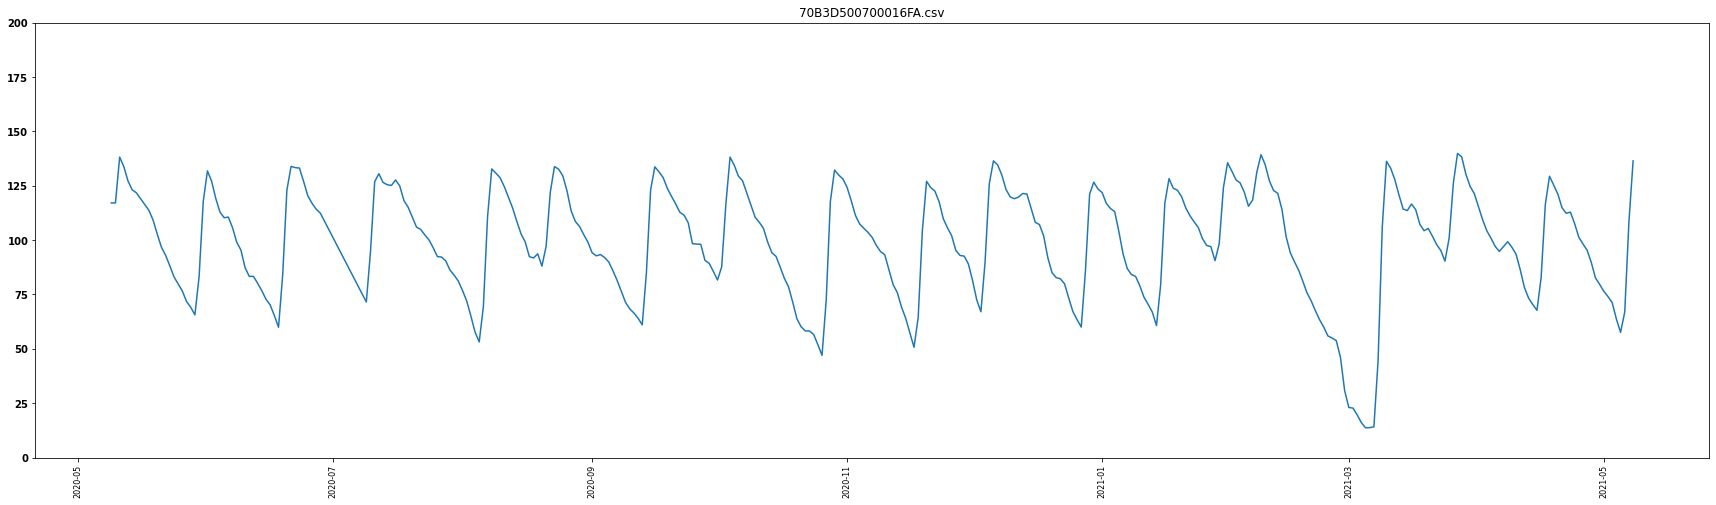

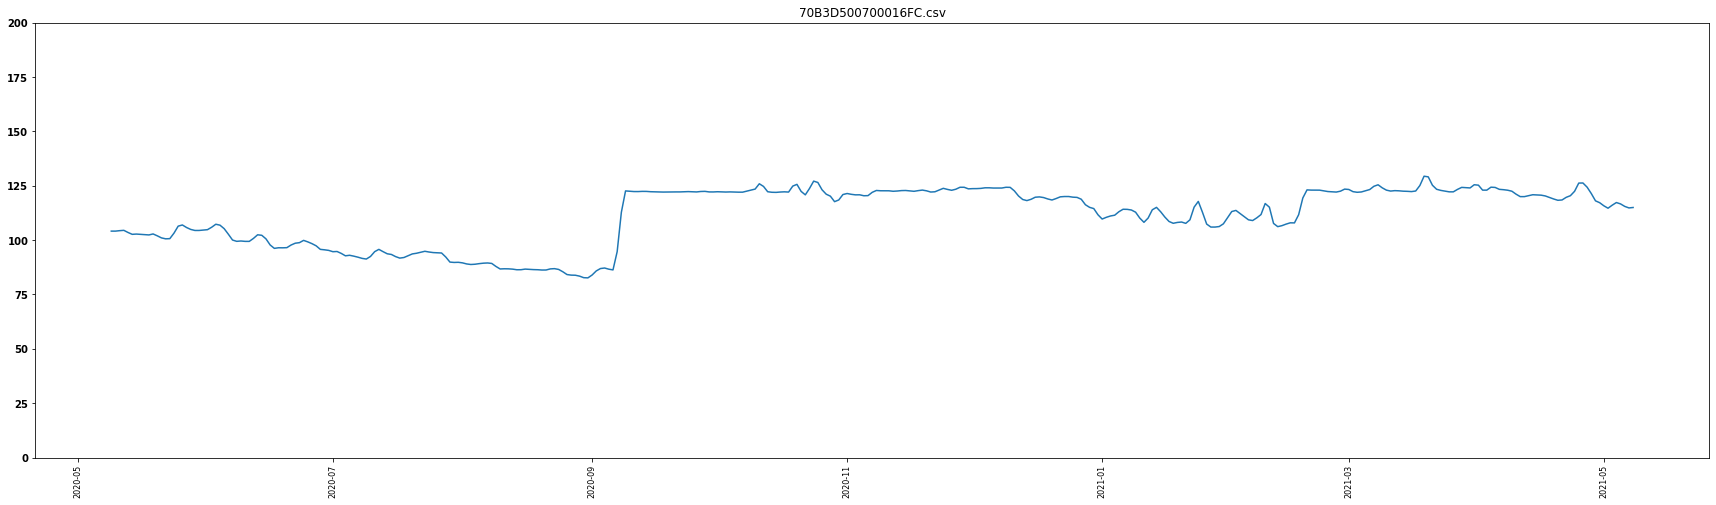

In [10]:
cluster_count = [0, 1, 2]
path_name = '../data/preprocessed/clusters/'

for i in cluster_count:
    dirName = path_name + str(i)
    #creating folders based on clusters and export files
    # Create target Directory if don't exist
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists") 

    print('Cluster ' + str(i))

    for series, clust in clusters.items():

        if clust == i:          
            df = pd.read_csv('../data/preprocessed/good_csv/' + series)

            df = cleaning_del(df)
            df, grouped = smoothing_fillingNaN(df)

            df.to_csv(dirName + '/' + series)
            grouped.to_csv(dirName + '/g_' + series)

            plt.figure(figsize=(30,8))
            plt.ylim((0,200))
            plt.title(series)

            plt.xticks(fontsize=8, rotation=90)
            plt.yticks(fontsize=10, fontweight='bold')
            plt.plot(grouped['inter_pol'])

            plt.show()